In [2]:
import rasterio
import os, time, datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from dtw import *
from skimage.segmentation import felzenszwalb
from rasterio.features import shapes as rio_shapes
from shapely.geometry import shape
from shapely.geometry.multipolygon import MultiPolygon
import cv2
import math
from scipy.ndimage import uniform_filter
from datetime import datetime
from pygeosys.timeserie.smoothers import  whitw
import joblib
import warnings

warnings.filterwarnings("ignore") #Hide messy numpy warnings
pd.options.display.float_format ='{:.2f}'.format

In [3]:
data_path = 'data/'  # path for image time series, each stocked in a file folder named with the sfd_id
modis= 'MODIS/'
image= 'MultiSpectral/'
sar = 'SAR/' # with-out just RVI
data_modis = data_path + modis
data_image = data_path + image
data_sar = data_path + sar

In [4]:
dataPath = 'CSV_Data/'
# file = 'SoyExRains_11.csv'
file = 'SoyExRains.csv'
data = pd.read_csv(dataPath+file, sep=';')
data = pd.DataFrame(data)

usecols = ['sfd_id','WKT']
rename = {
            'WKT': 'geometry',
            'sfd_id': 'Sfd_id'
}
data = data[usecols]
data.rename(columns=rename, inplace=True)

data

Sfd_id                                           geometry
0  104839603  MULTIPOLYGON (((-50.28868413 -21.21892931,-50....
1  104851010  MULTIPOLYGON (((-51.64726684 -23.30727236,-51....
2  104851011  MULTIPOLYGON (((-51.64079547 -23.29584802,-51....
3  104856056  MULTIPOLYGON (((-51.2694129 -23.23388657,-51.2...
4  104856307  MULTIPOLYGON (((-51.86434054 -22.80493581,-51....
5  104838039  MULTIPOLYGON (((-54.15842318 -25.22023698,-54....
6  104856508  MULTIPOLYGON (((-54.2316334 -20.94611016,-54.2...
7  104852841  MULTIPOLYGON (((-49.32213409 -23.02007774,-49....

In [5]:
sfd_ids = data['Sfd_id'].unique() 
# idx = 0 # done-5
# sfd_ids = np.array(sfd_ids[idx:idx+1])
sfd_ids = np.array(sfd_ids[:])
savePath = 'Sar_Rescontruction_Result/SAR_Rescontruction_wFEngi/'
sfd_ids

array([104839603, 104851010, 104851011, 104856056, 104856307, 104838039,
       104856508, 104852841], dtype=int64)

# Function

In [7]:
def Load_Dataset(sfd_ids,save=False):
    '''    
    Aggregrate all the data into a dataset
    ----------
    Attributes:
    sfd_ids : np.array
        List of field id
    ----------
    Returns:    
    df_dataset : pd.DataFrame   
    ----------
    Example:    
    df_dataset = Load_Dataset(sfd_ids)
    '''   
    df_dataset = pd.DataFrame()
    index = 0
    title = f'{len(sfd_ids)}_fields_dataset'
    for sfd_id_choice in sfd_ids:
        df_load = pd.read_pickle(f'{savePath}/DataVariables/df_dataset_{sfd_id_choice}.pkl')
        df_load.insert(0, "id", [index for idx in range(len(df_load))], True)
        df_load.insert(0, "field_id", [sfd_id_choice for idx in range(len(df_load))], True)
        df_dataset = pd.concat([df_dataset,df_load]).reset_index(drop=True)
        index+=1
    
    df_dataset['Date'] = pd.to_datetime(df_dataset['Date'],format='%Y%m%d')
    df_dataset['Date'] = df_dataset['Date'].dt.strftime('%d%m%y')
    if save:
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')        
        df_dataset.to_csv(f'{savePath}/{title}.csv',index=False)
        df_dataset.to_pickle(f'{savePath}/{title}.pkl')
    return df_dataset

### Explanatory  
def StatisclVisualization(df_dataset,stasticalFeatures,title,save=False):
    '''    
    Visualize the Statistics of the Images 
    VV-VH-MODIS
    ----------
    Attributes:
    df_dataset: pd.DataFrame
        dataset
    
    stasticalFeatures: list
        list of statistical features
    stasticalFeatures = ['VV_mean', 'VV_std', 'VV_med', 'VV_max',
         'VV_min', 'VH_mean', 'VH_std', 'VH_med',
         'VH_max', 'VH_min', 'modis_mean', 'modis_std',
         'modis_med', 'modis_max', 'modis_min','NDVI_mean']
    ----------
    Returns:    
    df_dataset : pd.DataFrame   
    ----------
    Example:      
    StatisclVisualization(df_dataset,stasticalFeatures,save=False)
    '''
    # title = 'Stastical_Visualization'
    fig, ax = plt.subplots(nrows= len(stasticalFeatures), ncols=1 , figsize=(25,50))  
    for idx in range(len(stasticalFeatures)):   
        ax[idx].plot(df_dataset[stasticalFeatures[idx]])        
        # Set the colorbar scale
        #ax.set_ylim(vmin=0, vmax=1)
        ax[idx].grid()
        ax[idx].set_title(f'{stasticalFeatures[idx]}')
    
    if save:
        if not os.path.exists(f'{savePath}/Images/'):
            os.makedirs( f'{savePath}/Images/')        
        fig.savefig(f'{savePath}/Images/{title}.png')

def BoxPlot(df_dataset,stasticalFeatures,title,figsize=(3,2),save=False):
    '''       
    Visualize the Box Plot of Statistics of the Images 
    ----------
    Attributes:
    df_dataset: pd.DataFrame
        dataset
    stasticalFeatures: list
        list of statistical features
    stasticalFeatures = ['VV_mean', 'VV_std', 'VV_med', 'VV_max',
         'VV_min', 'VH_mean', 'VH_std', 'VH_med',
         'VH_max', 'VH_min', 'modis_mean', 'modis_std',
         'modis_med', 'modis_max', 'modis_min','NDVI_mean']
    ----------
    Returns:    
    df_dataset : pd.DataFrame   
    ----------
    Example:      
    StatisclVisualization(df_dataset,stasticalFeatures,save=False)
        
    colors = ['pink', 'lightblue', 'lightgreen', 'yellow',None,None,'cyan']
    return: 
    BoxPlot(boxDataImpactedArea, boxTitle, Labels_disaster, ylabel, colors,)
    '''
    title = f'{stasticalFeatures}'
    data = df_dataset[stasticalFeatures]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    bp = ax.boxplot(data, 
                # labels = stasticalFeatures, 
                vert=True,  # vertical box alignment
                patch_artist=True,  # fill with color
                )
    # ax.set_xlabel('stastical_Features')
    # ax.set_ylabel('Value')
    ax.set_title(title)
    # for patch, color in zip(bp['boxes'], colors):
    #         patch.set_facecolor(color)
    plt.grid()
    plt.show()
    if save:
        if not os.path.exists(f'{savePath}/Images/'):
            os.makedirs( f'{savePath}/Images/')        
        fig.savefig(f'{savePath}/Images/{title}.png'),

def NDVI_plot(df_dataset,save=False):
    '''    
    Plot the label of dataset (NDVI_mean)
    ----------
    Attributes:
    df_dataset : pd.DataFrame
        Dataset dataframe    
    sfd_id_choice: 
        Chosed field
    save: bool, default=False
        Save the figure
    ----------
    Example:
    NDVI_plot(df_dataset,sfd_id_choice)
    '''    
    plt.figure(figsize =(15,5))
    title = 'NDVI'
    plt.title(title)
    #Date = df_dataset['Date']    
    NDVI = df_dataset['NDVI_mean']
    plt.plot(NDVI)
    plt.grid()
    #plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('NDVI')
    if save:
        if not os.path.exists(f'{savePath}/Images/'):
            os.makedirs( f'{savePath}/Images/')        
        plt.savefig(f'{savePath}/Images/{title}.png')
### Data processing
def DataFiltering(df_dataset,selectedFeautures):
    """
    Filter the dataset with specified condition: 
  ['VV_mean', 'VV_std', 'VV_med', 'VV_max','VV_min',
   'VH_mean', 'VH_std', 'VH_med','VH_max', 'VH_min',
   'modis_mean', 'modis_std','modis_med', 'modis_max', 'modis_min', (modis mean/med/max/min)
   'NDVI_mean']
    ----------
    Attributes:
    df_dataset : pd.DataFrame 
    ----------
    Returns:    
    df_dataset : pd.DataFrame 
        filtered DataFrame
    ----------
    Example:
    df_filtered_dataset = DataFiltering(df_dataset)
    """
    to_delete = []    
    for feature in selectedFeautures:
        mean = df_dataset[feature].mean()
        std = df_dataset[feature].std()
        upper = mean+2*std
        lower = mean-2*std
        if feature in ['VV_max','VV_min']:
            upper = 1
            lower = -1
        for idx,row in df_dataset.iterrows():
            if row[feature] < lower or row[feature] > upper :
                to_delete.append(idx)
    df_dataset = df_dataset.drop(to_delete)
    df_dataset = df_dataset.reset_index(drop=True)
    return df_dataset

from sklearn.preprocessing import MinMaxScaler
def FeatureScaling(df_dataset,features,save=False):
    """
    Scale the feature with specified condition
    ----------
    Attributes:
    df_dataset : pd.DataFrame 
    ----------
    Returns:    
    df_dataset : pd.DataFrame 
        scaled DataFrame
    ----------
    Example:
    features = ['SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med']
    df_scaled_dataset = FeatureScaling(df_dataset,features)
    # Inverse scale
    predictions = scaler.inverse_transform(predictions)
    joblib.dump(my_scaler, 'scaler.gz')
    """     
    df = df_dataset.copy()
    for feature in features:
        scaler = MinMaxScaler()
        data = df[feature].values.reshape(-1,1)        
        scaler = scaler.fit(data)
        scaled_data = scaler.transform(data)
        df[feature] = scaled_data        
        if save:
            if not os.path.exists(f'{savePath}/'):
                os.makedirs( f'{savePath}/')   
            title = f'{savePath}/{feature}_scaler.gz'
            joblib.dump(scaler, title)              
    
    return df    

def Exponential_weighted_average(data,beta=0.65):
    '''    
    Smooth the curve
    Smooth method: weighted_average
    ----------
    Attributes:
    data : np.array
    ----------
    Returns:    
    res : list
        smoothed list
    ----------
    Example:
    smoothedData = Exponential_weighted_average(data,beta=0.55)    
    '''    
    smoothedData =[data[0]]    
    for idx in range(len(data)):        
        smoothedData.append(beta*smoothedData[-1]+(1-beta)*data[idx])    
    return smoothedData[1:]

def whittaker(x, beta=10000):
    '''    
    Smooth the curve
    Smooth method: whittaker
    ----------
    Attributes:
    data : np.array
    ----------
    Returns:    
    res : array
        smoothed array
    ----------
    Example:
    from pygeosys.timeserie.smoothers import  whitw
    data = apply_smoother(df_dataset[feature].values,beta)
    '''        
    weights = (x[0])
    return whitw(x, weights, alpha=3, beta=beta)

def DataSmoothing(df,features,beta=10000):
    '''    
    Smooth the the data
    Smooth method: weighted_average
    ----------
    Attributes:
    df_dataset : pd.DataFrame
    features: list of features of the df_dataset
    ----------
    Returns:    
    df_dataset : pd.DataFrame 
        smoothed DataFrame
    ----------
    Example:
    features = ['SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med']
    df_smoothed_dataset = DataSmoothing(df_dataset,features,beta=0.65)
    # Smoothing for visualizing purpose only
    # df_smoothed_scaled_filterd_dataset = DataSmoothing(df_scaled_filterd_dataset,features,beta=0.65)
    '''    
    df_dataset = df.copy()
    for feature in features:
        data = whittaker(df_dataset[feature].values,beta)
        df_dataset[feature] = data
    return df_dataset  
### Relevant Feature Augmenter for classification problem
# 2 field
# df_dataset_0 = pd.read_pickle(f'{savePath}/DataVariables/df_dataset_104838039.pkl')
# df_dataset_0.insert(0, "id", [sfd_id_choice for idx in range(len(df_dataset_0))], True)
# df_dataset_0['Class'] = 0

# df_dataset_1 = pd.read_pickle(f'{savePath}/DataVariables/df_dataset_104839603.pkl')
# df_dataset_1.insert(0, "id", [104839603 for idx in range(len(df_dataset_1))], True)
# df_dataset_1['Class'] = 1
# df_dataset = pd.concat([df_dataset_0,df_dataset_1]).reset_index(drop=True)
# df_filtered_dataset = DataFiltering(df_dataset)
# df_scaled_filterd_dataset = FeatureScaling(df_filtered_dataset,features)

# timeseries_train = df_scaled_filterd_dataset.iloc[:,:-2]
# y_train=df_scaled_filterd_dataset[['id','Class']]
# y_train.drop_duplicates(inplace=True)
# y_train = y_train.set_index('id')
# y_train = y_train['Class']

# Single RelevantFeatureAugmenter
# augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='Date')
# augmenter.set_timeseries_container(timeseries_train)
# X_train = pd.DataFrame(index=y_train.index)
# y_pred = augmenter.fit_transform(X_train, y_train)
# Prediction
# augmenter.set_timeseries_container(timeseries_test)
# y_pred = augmenter.transform(X_test)

# pipeline = Pipeline([
#             ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='Date')),
#             ('regressor', RandomForestRegressor(n_estimators=15, max_depth=6,random_state=0)),
#             # ('classifier', RandomForestClassifier()),
#             ])
# X_train = pd.DataFrame(index=y_train.index)
# pipeline.set_params(augmenter__timeseries_container = timeseries_train)
# pipeline.fit(X_train, y_train)

# # Prediction
# pipeline.set_params(augmenter__timeseries_container = timeseries_test)
# x_test = pd.DataFrame(index=y_test.index)  
# y_pred = pipeline.predict(X_test) 

### To ordinal Date 
# Using x.toordinal())
# df_dataset.insert(1, "DoY", df_dataset['Date'].apply(lambda x:x.toordinal()), True)
# features = ['DoY','id','SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med','year_id'] 

### Plot The DoY figure
# df_dataset = df_dataset.set_index(['field_id','year'])    
# plt.figure(figsize =(15,5))
# title = f'{sfd_id_choice}_DoY'
# plt.title(title)
# Date = df_dataset.loc[sfd_id_choice,'Date']
# DoY = df_dataset.loc[sfd_id_choice,'DoY']
# plt.plot(Date,DoY)
# plt.grid()



# Main Code

## Data Injection

In [8]:
## all features
features = ['id','VV_mean','VV_std','VV_med','VV_max','VV_min','VH_mean','VH_std','VH_med','VH_max','VH_min','modis_mean','modis_std','modis_med','modis_max','modis_min','year_id']
selected = ['field_id','year','Date','id','year_id','DoY','VV_mean','VV_std','VV_med','VV_max','VV_min','VH_mean','VH_std','VH_med','VH_max','VH_min',
            'modis_mean','modis_std','modis_med','modis_max','modis_min','NDVI_mean']

## 6 features
# features = ['id','SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med','year_id'] 
# selected = ['field_id','year','Date','id','year_id','DoY','SAR_std','SAR_med','modis_mean','modis_med','NDVI_mean']

# one Field - modify the sfd_ids
# sfd_id_choice = 104839603

# All dataset
df_dataset = Load_Dataset(sfd_ids,save=False)
# Load dataset
# dataset = f'{savePath}8_fields_dataset.pkl'
# df_dataset = pd.read_pickle(dataset)

df_dataset['Date'] = pd.to_datetime(df_dataset['Date'],format='%d%m%y')
df_dataset['year'] = df_dataset['Date'].dt.strftime('%Y')
df_dataset['year_id'] = df_dataset['Date'].dt.strftime('%Y')

###d using DoY - Starting from the January 1st
# df_dataset.insert(1, "DoY", df_dataset['Date'].apply(lambda x:x.dayofyear), True)
# df_dataset['DoY'] = df_dataset['DoY']/365

### Using DoY given by crop season
def DateTransform(Input):
    Div = Input// 365
    if Div !=0 :
        res = Input - 365*Div
        res /= 365 # Scale
    else: 
        res = Input/365
    return res
# 2018-10-01 - The start of first crop
df_dataset['DoY'] = df_dataset['Date'].sub(pd.Timestamp('2018-10-01')).dt.days #+ 1
df_dataset['DoY'] = df_dataset['DoY'].apply(DateTransform)

In [9]:
df_dataset

field_id  id       Date  VV_mean  VV_std  VV_med  VV_max  VV_min  \
0    104839603   0 2019-01-13     0.07    0.03    0.06    0.27    0.01   
1    104839603   0 2019-01-25     0.05    0.03    0.05    0.34    0.01   
2    104839603   0 2019-02-01     0.05    0.02    0.04    0.22    0.01   
3    104839603   0 2019-02-06     0.05    0.02    0.04    0.23    0.00   
4    104839603   0 2019-03-09     0.04    0.02    0.04    0.22    0.01   
..         ...  ..        ...      ...     ...     ...     ...     ...   
520  104852841   7 2021-08-01     0.08    0.04    0.07    0.34    0.01   
521  104852841   7 2021-09-06     0.05    0.02    0.05    0.23    0.01   
522  104852841   7 2021-11-05     0.03    0.02    0.03    0.30    0.00   
523  104852841   7 2021-11-17     0.05    0.03    0.05    0.34    0.01   
524  104852841   7 2021-12-11     0.08    0.04    0.07    0.32    0.01   

     VH_mean  VH_std  ...  VH_min  modis_mean  modis_std  modis_med  \
0       0.01    0.01  ...    0.00        0.55       0.02       0.54   
1       0.01    0.01  ...    0.00        0.51       0.02       0.51   
2       0.01    0.01  ...    0.00        0.42       0.03       0.41   
3       0.01    0.01  ...    0.00       -0.00       0.00      -0.00   
4       0.01    0.01  ...    0.00        0.48       0.03       0.46   
..       ...     ...  ...     ...         ...        ...        ...   
520     0.02    0.01  ...    0.00        0.00       0.00       0.00   
521     0.01    0.01  ...    0.00        0.39       0.03       0.36   
522     0.00    0.00  ...    0.00        0.56       0.01       0.56   
523     0.01    0.01  ...    0.00        0.11       0.01       0.11   
524     0.01    0.01  ...    0.00        0.56       0.03       0.57   

     modis_max  modis_min  NDVI_mean  year  year_id  DoY  
0         0.63       0.54       0.49  2019     2019 0.28  
1         0.52       0.46       0.38  2019     2019 0.32  
2         0.50       0.41       0.25  2019     2019 0.34  
3         0.00      -0.01       0.22  2019     2019 0.35  
4         0.62       0.46       0.15  2019     2019 0.44  
..         ...        ...        ...   ...      ...  ...  
520       0.01       0.00       0.29  2021     2021 0.84  
521       0.43       0.33       0.17  2021     2021 0.93  
522       0.56       0.53       0.18  2021     2021 0.10  
523       0.15       0.11       0.26  2021     2021 0.13  
524       0.62       0.51       0.51  2021     2021 0.20  

[525 rows x 22 columns]

## Statistical Visualization

In [11]:
stasticalFeatures = ['VV_mean', 'VV_std', 'VV_med', 'VV_max',
         'VV_min', 'VH_mean', 'VH_std', 'VH_med',
         'VH_max', 'VH_min', 'modis_mean', 'modis_std',
         'modis_med', 'modis_max', 'modis_min','NDVI_mean']
df_dataset[stasticalFeatures].describe()

VV_mean  VV_std  VV_med  VV_max  VV_min  VH_mean  VH_std  VH_med  \
count   525.00  525.00  525.00  525.00  525.00   525.00  525.00  525.00   
mean      0.08    0.05    0.07    1.14   -0.52     0.02    0.01    0.01   
std       0.04    0.14    0.04    5.78    5.40     0.01    0.00    0.01   
min       0.02    0.01    0.01    0.11 -114.06     0.00    0.00    0.00   
25%       0.05    0.02    0.04    0.22    0.00     0.01    0.01    0.01   
50%       0.07    0.03    0.06    0.30    0.01     0.01    0.01    0.01   
75%       0.11    0.04    0.10    0.46    0.01     0.02    0.01    0.02   
max       0.25    2.62    0.25   88.70    0.04     0.05    0.02    0.05   

       VH_max  VH_min  modis_mean  modis_std  modis_med  modis_max  modis_min  \
count  525.00  525.00      525.00     525.00     525.00     525.00     525.00   
mean     0.09    0.00        0.47       0.02       0.47       0.52       0.43   
std      0.10    0.00        0.22       0.03       0.22       0.23       0.22   
min      0.02   -0.00       -0.03       0.00      -0.03      -0.03      -0.03   
25%      0.05    0.00        0.33       0.00       0.33       0.37       0.29   
50%      0.07    0.00        0.48       0.01       0.48       0.55       0.43   
75%      0.09    0.00        0.62       0.03       0.63       0.69       0.57   
max      1.00    0.01        0.93       0.21       0.93       0.94       0.92   

       NDVI_mean  
count     525.00  
mean        0.44  
std         0.24  
min         0.12  
25%         0.23  
50%         0.36  
75%         0.65  
max         0.93

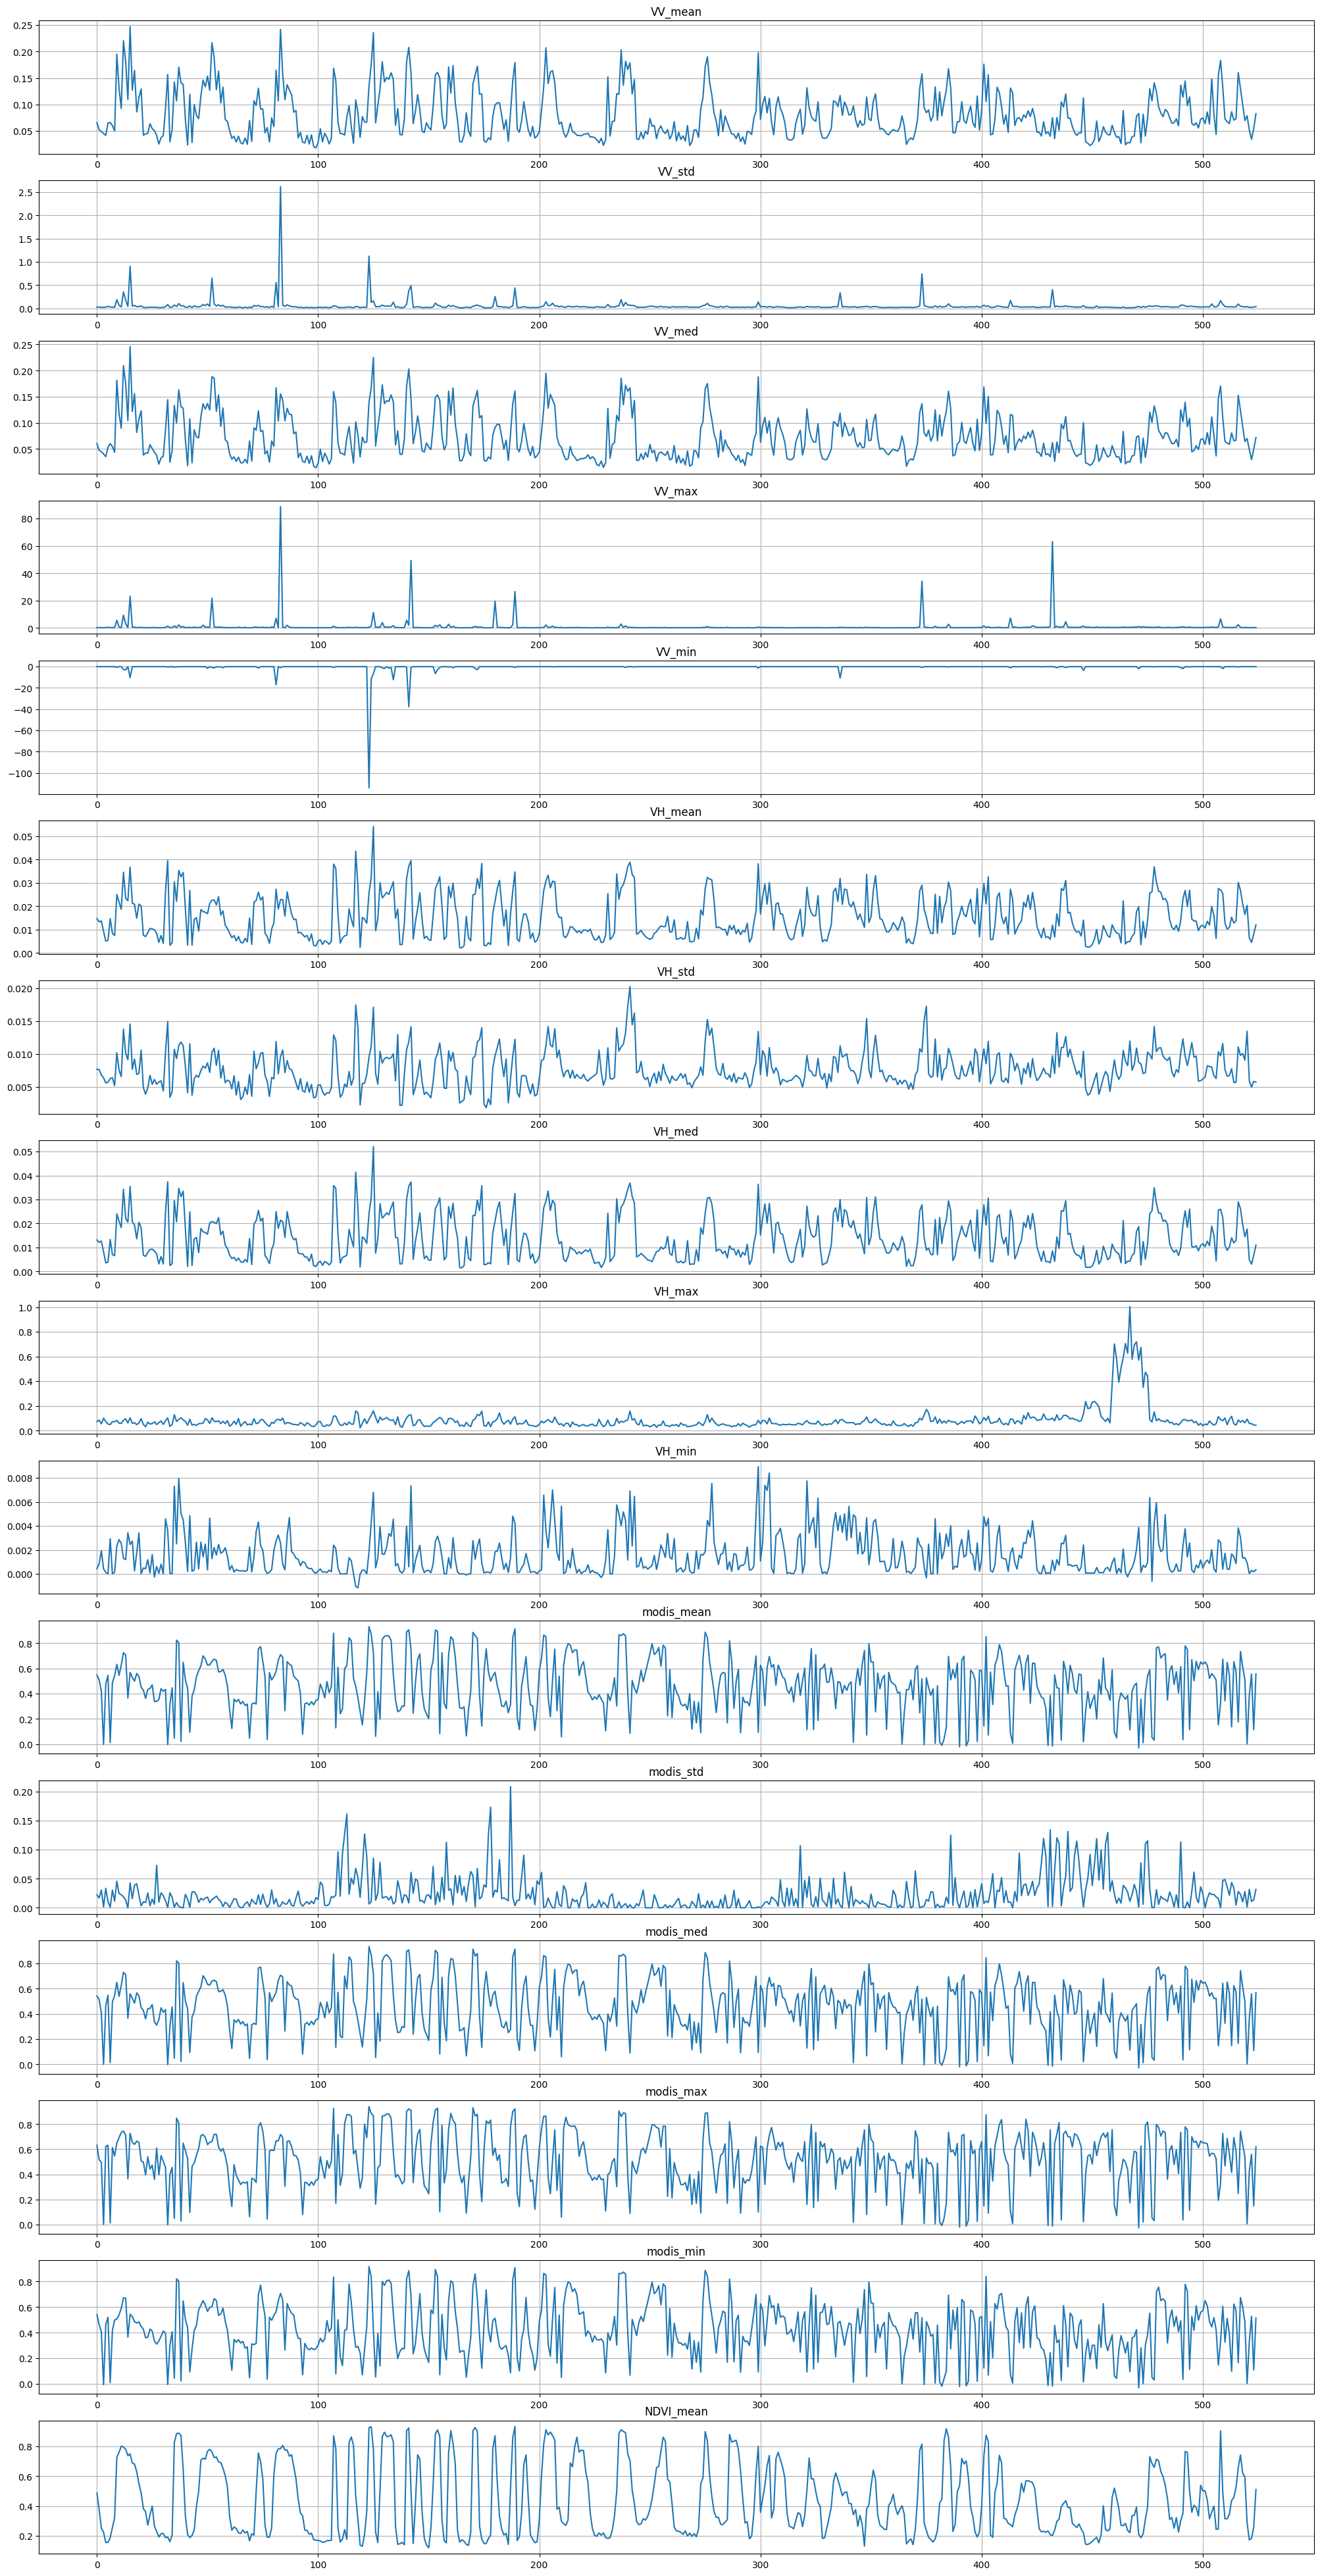

In [12]:
title = 'Stastical_Visualization'
StatisclVisualization(df_dataset,stasticalFeatures,title,save=True)

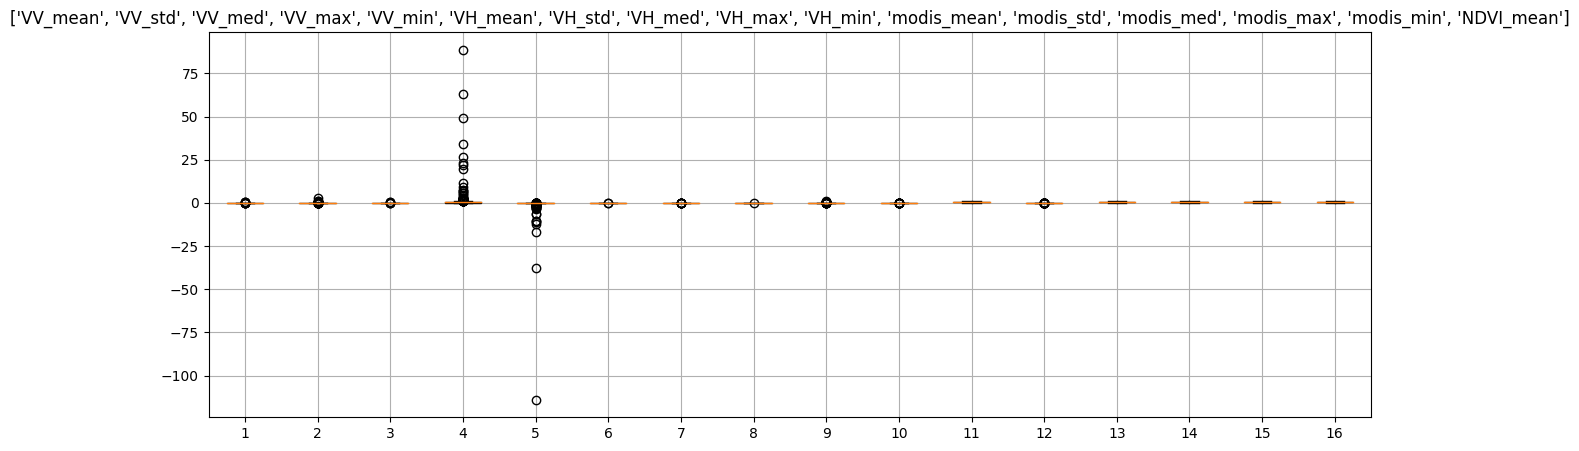

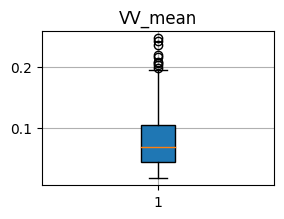

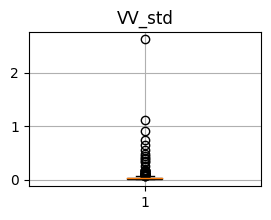

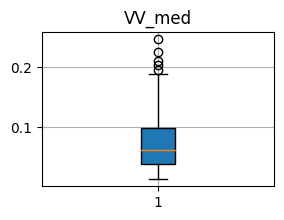

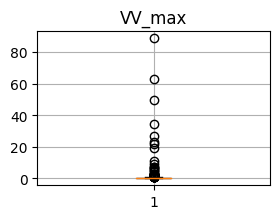

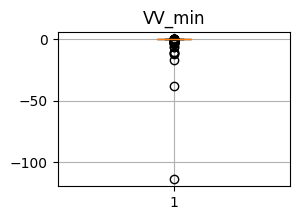

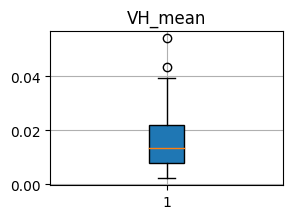

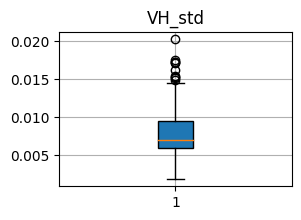

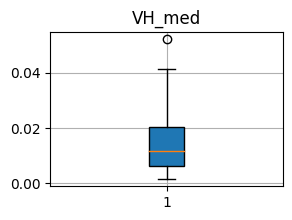

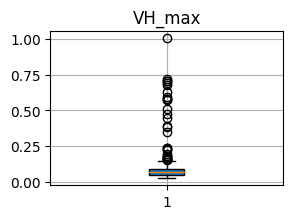

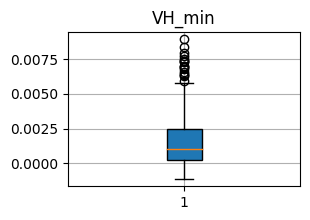

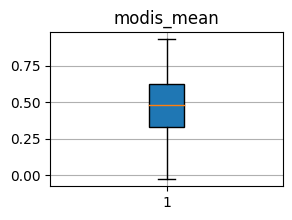

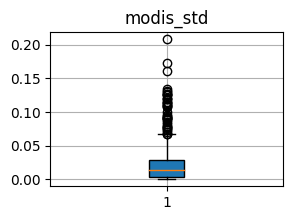

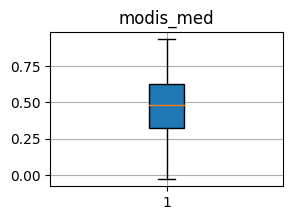

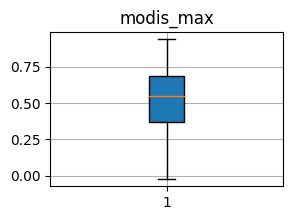

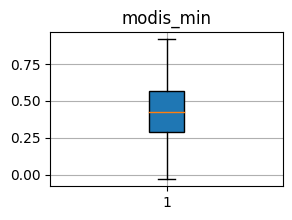

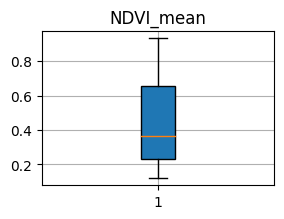

In [13]:
title = 'Box Plot of Statistical Features'
# Visualize all features 
BoxPlot(df_dataset,stasticalFeatures,title,figsize=(15,5),save=False)
# Visualize each feature
for fea in stasticalFeatures:
    BoxPlot(df_dataset,fea,title,save=False)

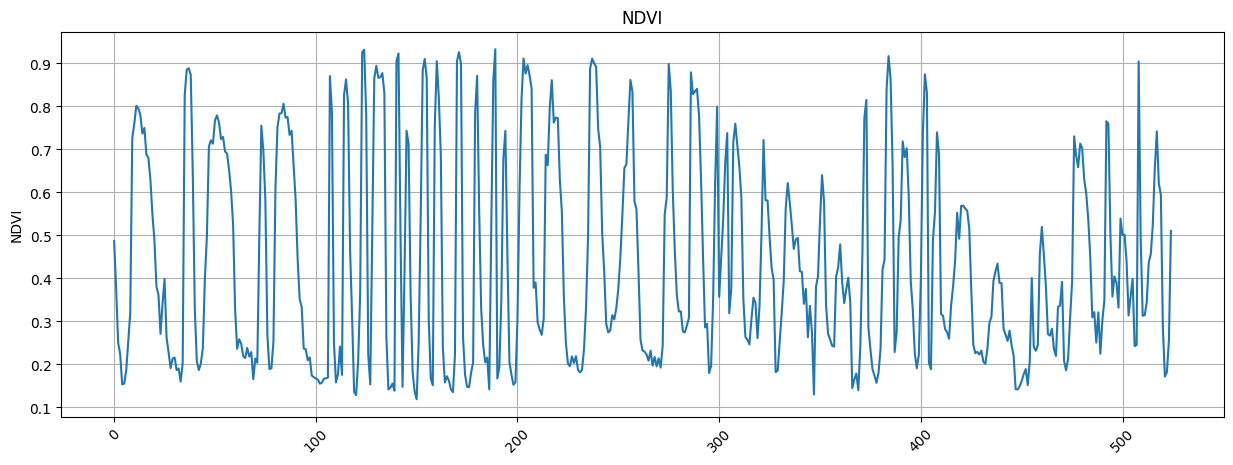

In [104]:
NDVI_plot(df_dataset,save=False)

Conclusion:
- Need the outlier Removal of VV_std/VV_max/VV_min/VH_std/VH_max/VH_min/modis_std/

### Data filtering process

In [159]:
selectedFeatures = ['VV_mean', 'VV_std', 'VV_med', 'VV_max','VV_min', 
                    'VH_mean', 'VH_std', 'VH_med','VH_max', 'VH_min',  
                    'modis_std', 'modis_max', 'modis_min',
                    ]
df_filtered_dataset = DataFiltering(df_dataset,selectedFeatures)

In [161]:
df_filtered_dataset[stasticalFeatures].describe()

VV_mean  VV_std  VV_med  VV_max  VV_min  VH_mean  VH_std  VH_med  \
count   372.00  372.00  372.00  372.00  372.00   372.00  372.00  372.00   
mean      0.07    0.03    0.06    0.30    0.00     0.01    0.01    0.01   
std       0.03    0.01    0.03    0.14    0.07     0.01    0.00    0.01   
min       0.02    0.01    0.01    0.11   -0.95     0.00    0.00    0.00   
25%       0.04    0.02    0.04    0.20    0.01     0.01    0.01    0.01   
50%       0.06    0.03    0.05    0.26    0.01     0.01    0.01    0.01   
75%       0.08    0.04    0.08    0.35    0.01     0.02    0.01    0.02   
max       0.16    0.09    0.16    0.86    0.03     0.03    0.01    0.03   

       VH_max  VH_min  modis_mean  modis_std  modis_med  modis_max  modis_min  \
count  372.00  372.00      372.00     372.00     372.00     372.00     372.00   
mean     0.06    0.00        0.48       0.02       0.48       0.52       0.45   
std      0.03    0.00        0.18       0.02       0.18       0.18       0.17   
min      0.02   -0.00        0.05       0.00       0.05       0.06       0.05   
25%      0.05    0.00        0.35       0.01       0.35       0.39       0.33   
50%      0.06    0.00        0.49       0.01       0.49       0.54       0.45   
75%      0.07    0.00        0.61       0.03       0.61       0.65       0.56   
max      0.24    0.01        0.89       0.08       0.91       0.93       0.84   

       NDVI_mean  
count     372.00  
mean        0.40  
std         0.22  
min         0.12  
25%         0.22  
50%         0.33  
75%         0.56  
max         0.92

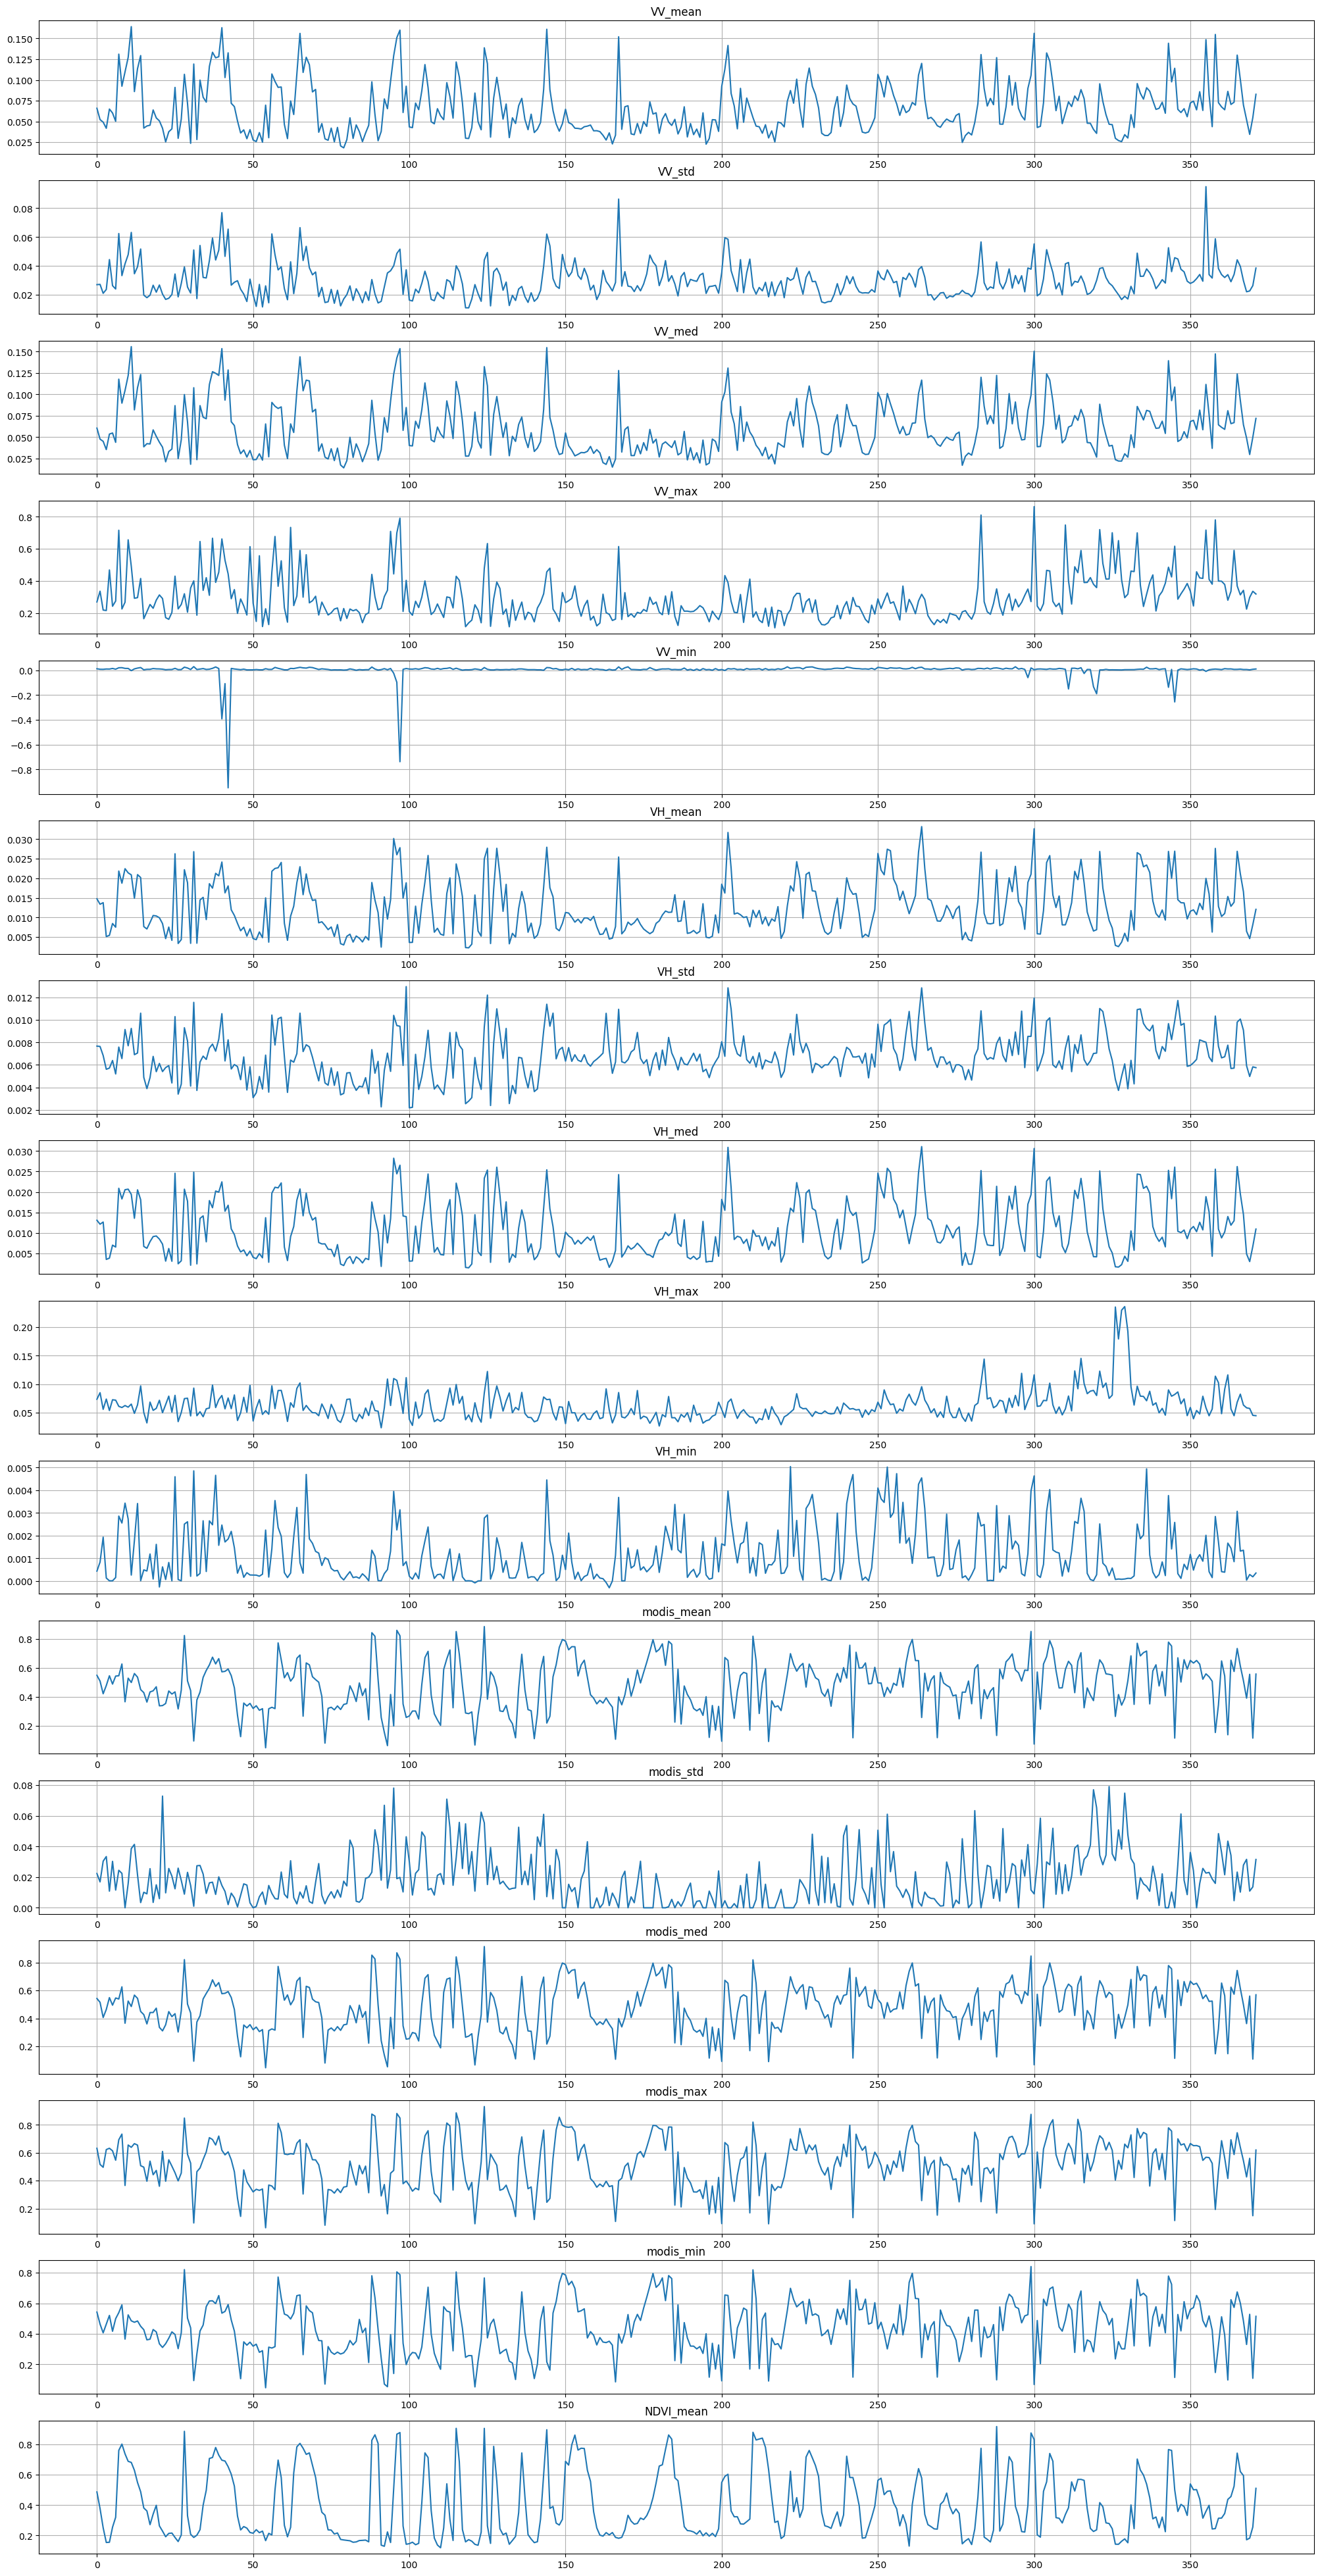

In [160]:
title = 'Filtered_Stastical_Visualization'
StatisclVisualization(df_filtered_dataset,stasticalFeatures,title,save=True)

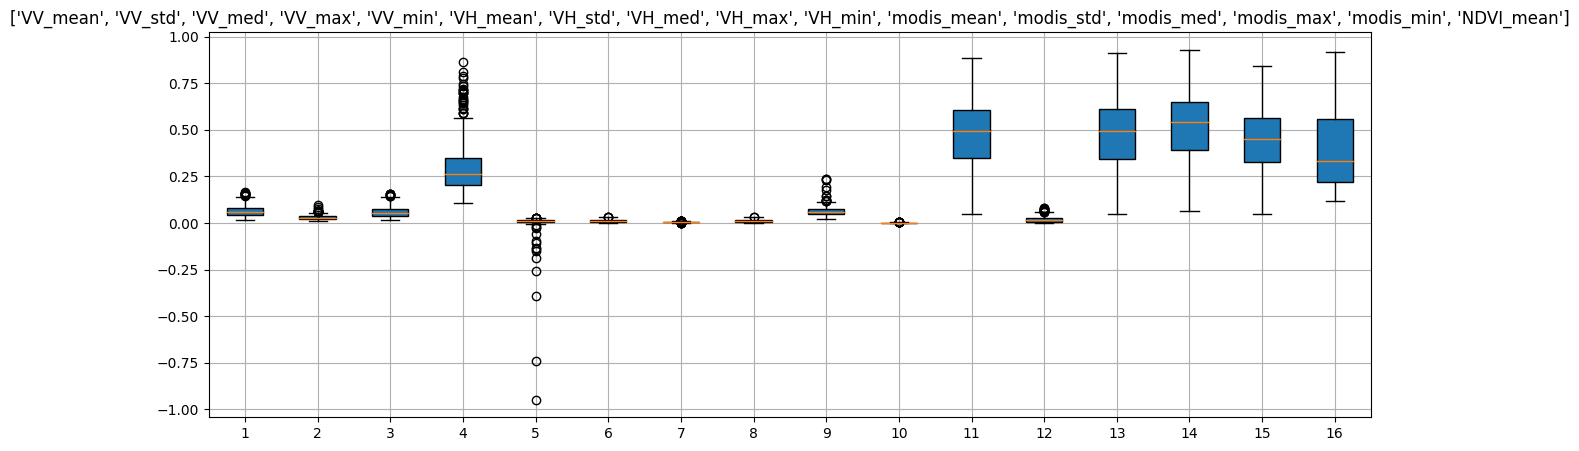

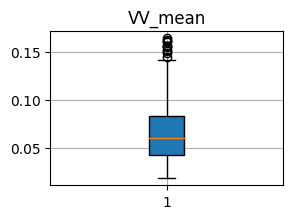

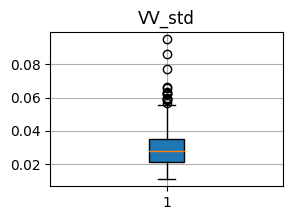

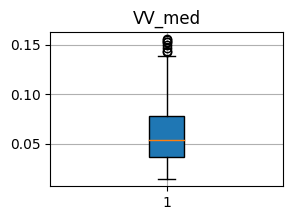

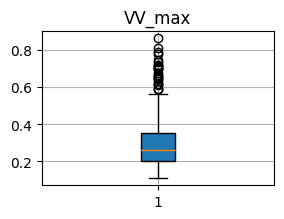

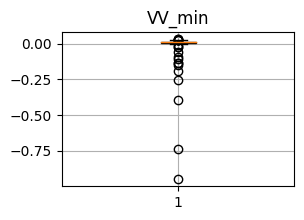

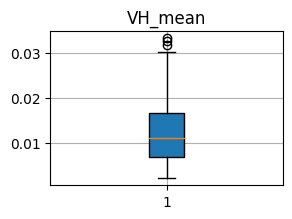

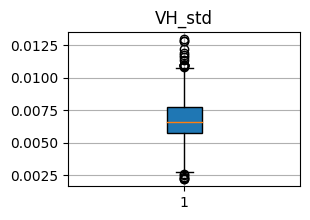

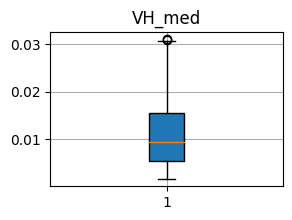

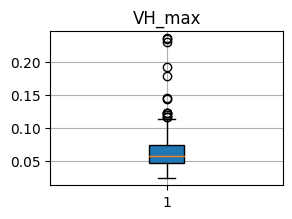

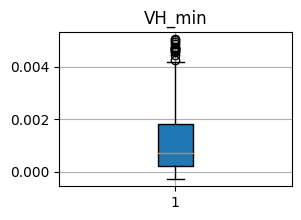

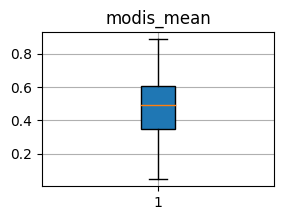

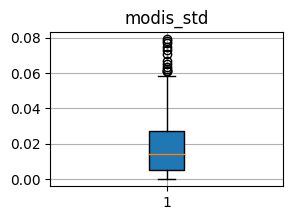

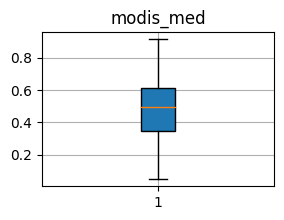

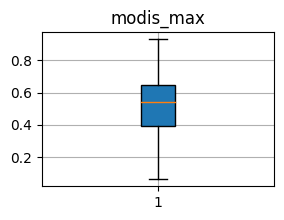

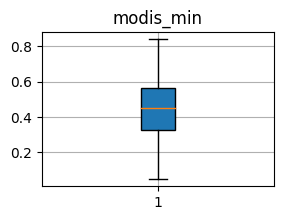

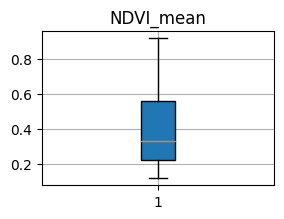

In [164]:
title = 'Box Plot of Filtered Features'
# Visualize all features 
BoxPlot(df_filtered_dataset,stasticalFeatures,title,figsize=(15,5),save=False)
# Visualize each feature
for fea in stasticalFeatures:
    BoxPlot(df_filtered_dataset,fea,title,save=False)

## Data processing

In [165]:
filteredFeatures = ['VV_mean', 'VV_std', 'VV_med', 'VV_max','VV_min', 
                    'VH_mean', 'VH_std', 'VH_med','VH_max', 'VH_min',  
                    'modis_std', 'modis_max', 'modis_min',
                    ]
df_filtered_dataset = DataFiltering(df_dataset,filteredFeatures)
scaledFeatures = ['id','VV_mean','VV_std','VV_med','VV_max','VV_min','VH_mean','VH_std','VH_med','VH_max','VH_min','modis_mean','modis_std','modis_med','modis_max','modis_min','year_id']
df_scaled_filterd_dataset = FeatureScaling(df_filtered_dataset,scaledFeatures,save=True)#####
smoothedFeatures = scaledFeatures[1:-1]
df_smoothed_scaled_filterd_dataset = DataSmoothing(df_scaled_filterd_dataset,smoothedFeatures)
df_smoothed_scaled_filterd_dataset.tail()

field_id   id       Date  VV_mean  VV_std  VV_med  VV_max  VV_min  \
367  104852841 1.00 2021-07-20     0.38    0.26    0.37    0.33    0.98   
368  104852841 1.00 2021-09-06     0.36    0.24    0.36    0.31    0.98   
369  104852841 1.00 2021-11-05     0.34    0.23    0.34    0.29    0.98   
370  104852841 1.00 2021-11-17     0.32    0.21    0.32    0.26    0.98   
371  104852841 1.00 2021-12-11     0.30    0.19    0.30    0.24    0.97   

     VH_mean  VH_std  ...  VH_min  modis_mean  modis_std  modis_med  \
367     0.34    0.44  ...    0.22        0.51       0.31       0.49   
368     0.33    0.42  ...    0.21        0.50       0.30       0.48   
369     0.31    0.41  ...    0.20        0.49       0.29       0.47   
370     0.29    0.40  ...    0.18        0.48       0.28       0.46   
371     0.27    0.38  ...    0.16        0.47       0.27       0.45   

     modis_max  modis_min  NDVI_mean  year  year_id  DoY  
367       0.53       0.49       0.59  2021     1.00 0.80  
368       0.52       0.48       0.17  2021     1.00 0.93  
369       0.50       0.48       0.18  2021     1.00 0.10  
370       0.49       0.48       0.26  2021     1.00 0.13  
371       0.47       0.47       0.51  2021     1.00 0.20  

[5 rows x 22 columns]

# Data Modeling

In [179]:
from sklearn.model_selection import train_test_split
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle
import seaborn as sb

WORKFLOW FOR ML(8 MAIN STEP) : (for Builing models)
- Defind the problem (Regression) and assembling a dataset (from GE)
- Choosing a measure of succes (Root - MSE and MAE)
- Evaluation protocal (K-*crossvalidation,... )
- Preparing the data (Data processing- using LEE despeckling for SAR)
- Develop the base model (for 1st working- RFR/XGBoost/SVR/Stack)
- HyperParameters Tuning + Consider model evaluation
- Sacling up (make model get overfit ) -> Increasing the dataset
- Regularization (overcome the overfit)

In [298]:
orderedFeatured = ['field_id','year','Date','id','DoY','VV_mean','VV_std','VV_med','VV_max','VV_min','VH_mean','VH_std','VH_med','VH_max','VH_min',
            'modis_mean','modis_std','modis_med','modis_max','modis_min','NDVI_mean']
 # Eliminate: # VV_std/VV_min/VH_std/modis_std - NonSmooth # id - year_id - DoY - VH_med - VH_max - VH_min - modis_med  -Smooth
# selected = ['field_id','year','Date','id','year_id','DoY','VV_mean','VV_std','VV_med','VV_max','VV_min','VH_mean','VH_std','VH_med','VH_max','VH_min',
#             'modis_mean','modis_std','modis_med','modis_max','modis_min','NDVI_mean']

In [299]:
# preprocessed_dataset = df_scaled_filterd_dataset[selected]
preprocessed_dataset = df_smoothed_scaled_filterd_dataset[orderedFeatured]
preprocessed_dataset.tail()

field_id  year       Date   id  DoY  VV_mean  VV_std  VV_med  VV_max  \
367  104852841  2021 2021-07-20 1.00 0.80     0.38    0.26    0.37    0.33   
368  104852841  2021 2021-09-06 1.00 0.93     0.36    0.24    0.36    0.31   
369  104852841  2021 2021-11-05 1.00 0.10     0.34    0.23    0.34    0.29   
370  104852841  2021 2021-11-17 1.00 0.13     0.32    0.21    0.32    0.26   
371  104852841  2021 2021-12-11 1.00 0.20     0.30    0.19    0.30    0.24   

     VV_min  ...  VH_std  VH_med  VH_max  VH_min  modis_mean  modis_std  \
367    0.98  ...    0.44    0.34    0.19    0.22        0.51       0.31   
368    0.98  ...    0.42    0.32    0.18    0.21        0.50       0.30   
369    0.98  ...    0.41    0.30    0.18    0.20        0.49       0.29   
370    0.98  ...    0.40    0.28    0.17    0.18        0.48       0.28   
371    0.97  ...    0.38    0.26    0.16    0.16        0.47       0.27   

     modis_med  modis_max  modis_min  NDVI_mean  
367       0.49       0.53       0.49       0.59  
368       0.48       0.52       0.48       0.17  
369       0.47       0.50       0.48       0.18  
370       0.46       0.49       0.48       0.26  
371       0.45       0.47       0.47       0.51  

[5 rows x 21 columns]

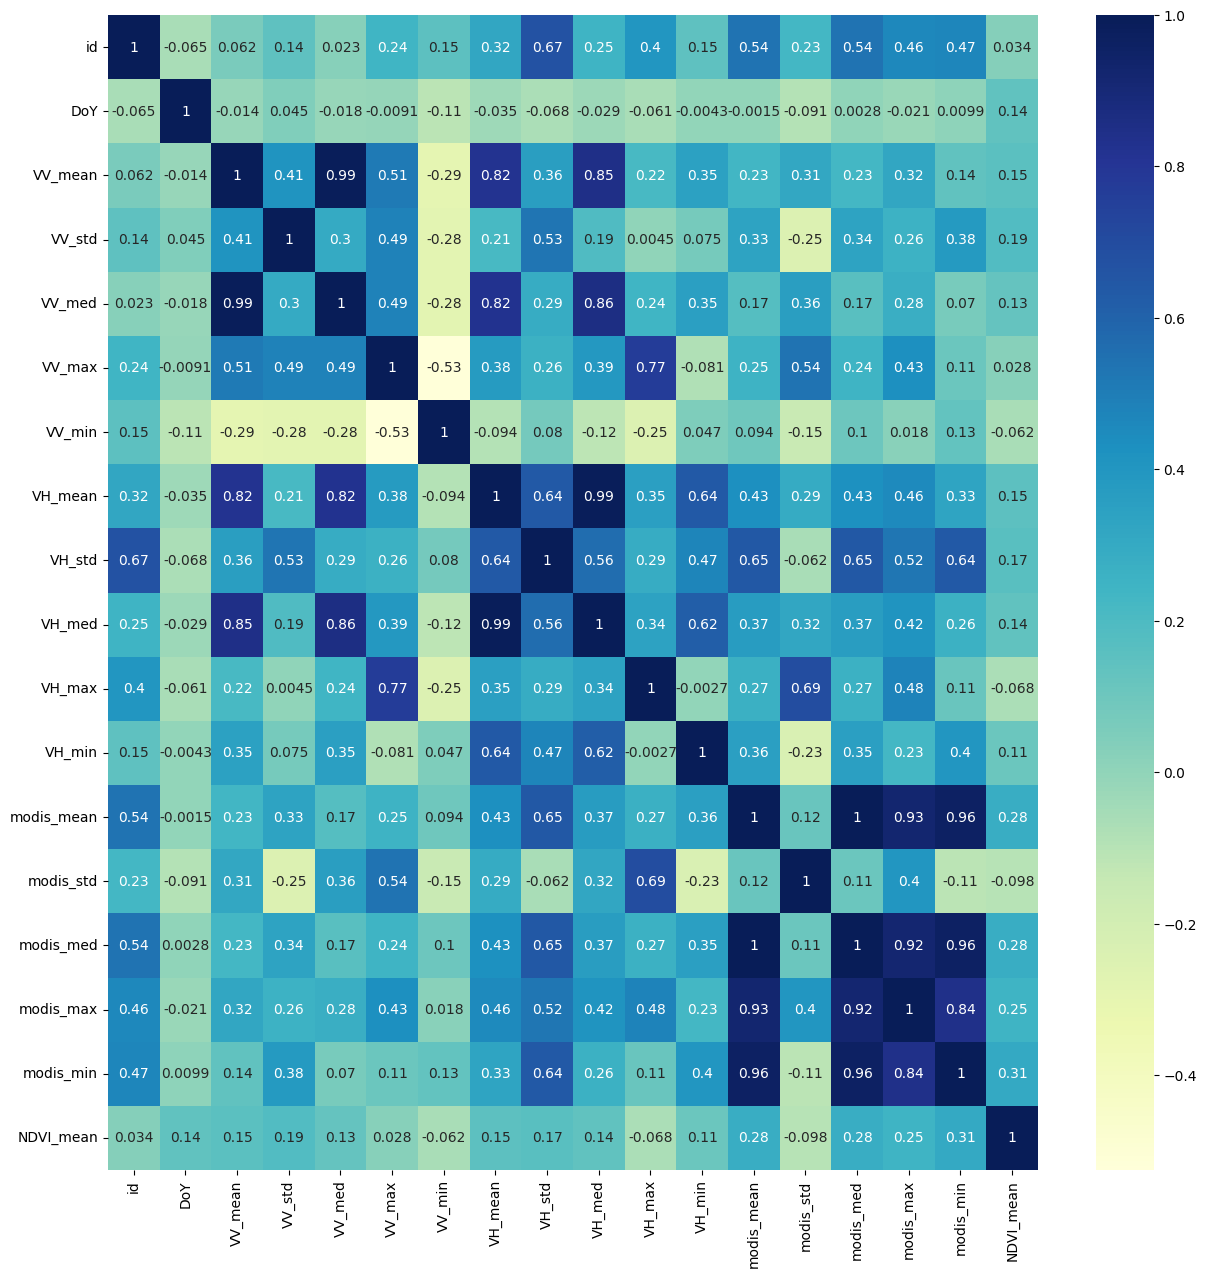

In [300]:
plt.figure(figsize=(15, 15))
train = df_smoothed_scaled_filterd_dataset[orderedFeatured[3:]]
dataplot = sb.heatmap(train.corr(), xticklabels=train.corr().columns, yticklabels=train.corr().columns,  cmap="YlGnBu", annot=True)
# plt.savefig('corr.png', bbox_inches="tight")
plt.show()

### Dimensional Reduction after Feature Selection

In [301]:
def ListSubtraction(orderedFeatured,subtrahendFeautres):
    for el in subtrahendFeautres:
        orderedFeatured.remove(el)
    return orderedFeatured

In [330]:
# Feature selection # VV_mean - VH_med - modis_mean
# subtrahend_Feautres = ['VV_mean','VH_med','modis_mean'] # from feature Selection 
subtrahend_Feautres = ['VV_max','VV_min','VH_max','modis_std'] #  correlation Matrix
differenceFeatured = ListSubtraction(orderedFeatured,subtrahend_Feautres)
preprocessed_dataset = df_smoothed_scaled_filterd_dataset[differenceFeatured]

ValueError: list.remove(x): x not in list

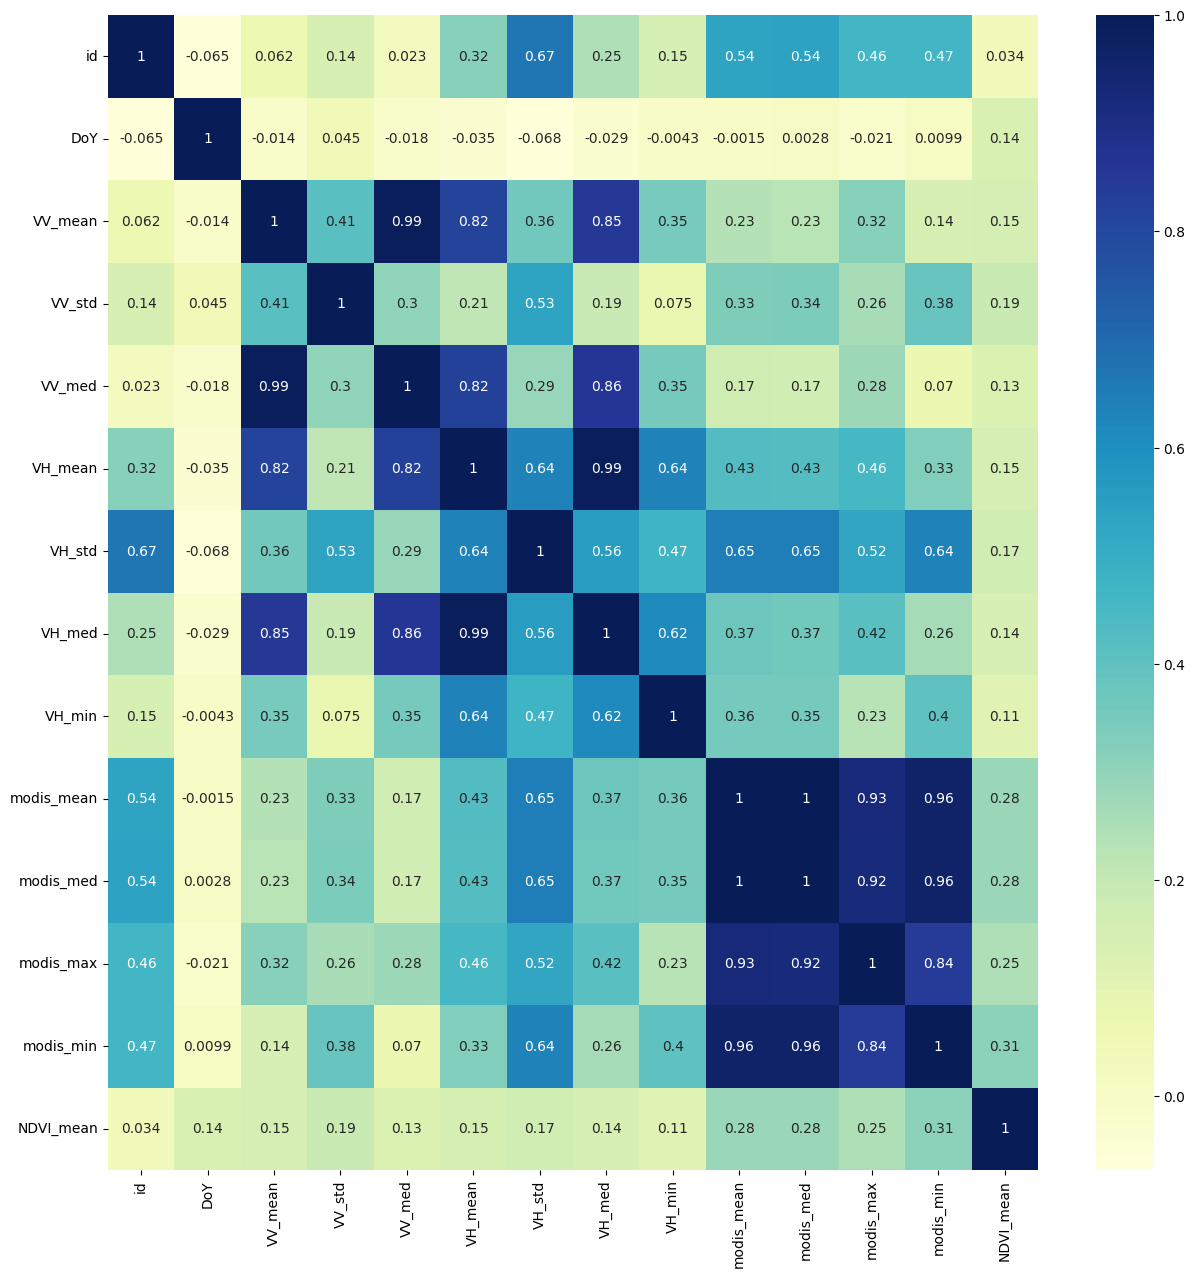

In [303]:
plt.figure(figsize=(15, 15))
train = df_smoothed_scaled_filterd_dataset[differenceFeatured[3:]]
dataplot = sb.heatmap(train.corr(), xticklabels=train.corr().columns, yticklabels=train.corr().columns,  cmap="YlGnBu", annot=True)
# plt.savefig('corr.png', bbox_inches="tight")
plt.show()

## Function

In [178]:
def DataSplitting_randomly(df):
    # Old Method 
    # DataSplitting_randomly(df_scaled_filterd_dataset)
    X = (df.iloc[:,1:-1]).astype('float')
    y = (df.iloc[:,-1]).astype('float')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def DataSplitting(df,sfd_ids,years,TestRatio = 0.1,random_state=0) :
    '''    
    Split the dataset:
    TrainingSet: keep all samples from the past to the last year
    TestingSet: separate only the last year according to the Test Ratio
    ----------
    Attributes:
    df : pd.DataFrame
        dataset having ['field_id','year'] and ['DoY']
    sfd_ids: list of fields 
    ----------
    Returns:        
    X_train, y_train: pd.DataFrame 
    X_test, y_test: pd.DataFrame    
    ----------
    Example:    
    sfd_ids= ['','']
    years = ['2019','2020','2021']
    X_train, X_test, y_train, y_test = DataSplitting(df_scaled_filterd_dataset,sfd_ids,years,TestRatio = 0.1,random_state=0)
    '''
    df = df.reset_index()
    df = df.set_index(['field_id','year','index']) 
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for sfd_id_choice in sfd_ids:
        df_2_last_year = pd.DataFrame()
        for year in years[:-1]:            
            df_2_last_year = pd.concat([df_2_last_year,df.loc[(sfd_id_choice,year),:]])        
        df_lastyear = df.loc[(sfd_id_choice,years[-1]),:]
        df_len = len(df.loc[sfd_id_choice])
        test_size = int(np.ceil(df_len*TestRatio))
        df_test_lastyear = df_lastyear.sample(n=test_size, random_state=random_state)
        DoY_lastyear = df_test_lastyear['DoY'].values.tolist()
        to_delete=[]
        for idx,row in df_test_lastyear.iterrows():
            if row['DoY'] in DoY_lastyear:
                to_delete.append(idx)    
        df_train_lastyear = df_lastyear.drop(to_delete,axis=0)    
        df_train = pd.concat([df_train,df_2_last_year,df_train_lastyear]).reset_index(drop=True)
        df_test = pd.concat([df_test,df_test_lastyear]).reset_index(drop=True)
    X_train = (df_train.iloc[:,1:-1]).astype('float')
    y_train = (df_train.iloc[:,-1]).astype('float')
    X_test = (df_test.iloc[:,1:-1]).astype('float')
    y_test = (df_test.iloc[:,-1]).astype('float')
    return X_train, X_test, y_train, y_test

### Model Evaluation
def FeaImpPlot(columns,weights):
    '''    
    Plot the feature importances of the tree-based models
    ----------
    Attributes:
    columns: List
        List of features of the figure
    weights: np.array
        The value array of the weights
    ----------
    Example:    
    FeaImpPlot(X.columns,model.feature_importances_)
    '''    
    # 
    plt.figure(figsize = (14,5))
    plt.bar(columns, weights)
    plt.xlabel('Features')
    plt.ylabel('Weight')
    plt.grid()
    plt.title('Feature Importances')
    
def test_validation(model,X_test,y_test,GP=False):
    '''    
    Create the test dataframe plus show the RMSE score between the observation and prediction
    Target less than 10%
    ----------
    Attributes:
    model : model
    X_test: pd.DataFrame
    y_test: pd.DataFrame
    ----------
    Returns:    
    test_df : pd.DataFrame
        Test Dataframe    
    ----------
    Example:    
    test_df, acc = test_validation(model,X_test,y_test)
    '''
    def BinaryTransform(Input):
        if Input > 0.1:
            res = 1
        else: 
            res = 0
        return res
    if GP:
        with torch.no_grad():
            # Gaussian Prediction
            test_x = torch.tensor(np.array(X_test))
            model.eval()
            likelihood.eval()
            observed_pred = likelihood(model(test_x)) 
            y_pred = observed_pred.mean.detach().numpy()
    else:
        y_pred = model.predict(X_test)
        
    test_dict = {'y_test':np.array(y_test),'y_pred':y_pred}
    test_df = pd.DataFrame(test_dict)
    test_df['diff'] = abs(test_df['y_test']-test_df['y_pred'])
    test_df['>0.1'] =  test_df['diff'].apply(BinaryTransform)
    fail_score = test_df['>0.1'].sum()
    acc = fail_score/len(test_df)
    # print('Test R2 score: {}'.format(r2_score(y_test,y_pred)))
    print('Test RMSE score: {:.2f}'.format(mean_squared_error(y_test, y_pred,squared=False)))
    print('Test MAE score: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
    print(f'The N.o samples larger than 0.1: {fail_score}')
    print(f'The Unacceptable Ratio: {acc:.2f}')
    return test_df, acc

def FeatureSelection(model,X_train,y_train,min_features_to_select=5):
    '''    
    Select the features of the model
    ----------
    Attributes:
    model : sklearn model
        model    
    X_train, y_train: pd.DataFrame
    ----------
    Example:
    FeatureSelection(model,X_train,y_train)
    '''    
    cv = KFold(n_splits=5, shuffle= True, random_state = 1)
    rfe = RFECV(model, min_features_to_select=5, step =1,cv=cv)
    rfe.fit(X_train,y_train)
    Dict = {
            'Features': X_train.columns,
            'Importance': rfe.support_}
    return pd.DataFrame(Dict)

### Movel Improvement
def HyperTuningPlot(para_list,score_text,score_train):
    
    '''
    para_list = C_list
    TuningPlot(para_list,score_text,score_train)
    '''
    plt.figure(figsize=(10,5))
    plt.plot(para_list,score_text, color='blue',  label='test_accuracy')
    plt.plot(para_list,score_train, color='red',  label='val_accuracy')
    plt.xlabel("para")
    plt.ylabel("RMSE")
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    print("The optimal parameter",C_list[score_text== min(score_text)])

def TrainingModel(untrained_model,X_train,y_train,scoring):
    '''
    model = RandomForestRegressor(n_estimators=36, max_depth=16,random_state=0)
    model.fit(X_train,y_train)
    cv = KFold(n_splits=5, shuffle= True, random_state = 1)
    scoring = 'neg_root_mean_squared_error'

    Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring)
    score = Val_score.mean()
    print(f'Val Loss: {-score:.2f}')
    test_df, acc = test_validation(model,X_test,y_test)
    # test_df
    '''
    cv = KFold(n_splits=5, shuffle= True, random_state = 1)    
    model = untrained_model.fit(X_train,y_train)    
    # https://scikit-learn.org/stable/modules/model_evaluation.html    
    Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring)
    score = Val_score.mean()
    print(f'Val Loss: {-score:.2f}')
    return model, score

    
def SaveModel(model,savePath,title):
    '''    
    Save Model
    ----------
    Attributes:
    model : model from ML
    save_path: saving repository
    title: str  
    ----------     
    Example:    
    SaveModel(model,savePath,'RFR_8field_Tuned_model.sav')
    '''    
    if not os.path.exists(f'{savePath}/model'):
        os.makedirs( f'{savePath}/model')
    filename = f'{savePath}/model/{title}'
    pickle.dump(model, open(filename, 'wb'))        
    
def loadModel(loadPath,title):
    '''    
    Load Model
    ----------
    Attributes:
    loadPath: loading repository
    title: str  
    ----------     
    Example:    
    loaded_model = loadModel(savePath,'RFR_8field_Tuned_model.sav')
    '''    
    filename = f'{savePath}/model/{title}'
    return pickle.load(open(filename,'rb'))

def Pred_Obs_plot(df_dataset,sfd_id_choice,model,feature_selected,acc,years=None,GB=False,Confident_drawing=False,save=False):
    '''    
    Plot the label of dataset and its prediction (NDVI_mean)
    ----------
    Attributes:
    df_dataset : pd.DataFrame
        Dataset dataframe    
    sfd_id_choice: 
        Chosed field
    model: sklearn model
    feature_selected: list
        list of featured selects
        feature_selected = ['id','DoY','SAR_std','SAR_med','modis_mean','modis_med']
    years: list
        chosed years for prediction
    save: bool, default=False
        Save the figure
    ----------
    Example:
    Pred_Obs_plot(df_dataset,sfd_id_choice,model,selected[3:-1],acc,GB=False,years=None,save=False)
    '''    
    df_dataset = df_dataset.set_index(['field_id','year'])    
    plt.figure(figsize =(15,5))
    title = f'{sfd_id_choice}_NDVI_means_Acc:{acc:.2f}'
    plt.title(title)
    Date = df_dataset.loc[sfd_id_choice,'Date']
    NDVI = df_dataset.loc[sfd_id_choice,'NDVI_mean']
    
    #HighlightedDate = df_dataset.loc[(sfd_id_choice,'2021'),'Date'].to_list()[0]
    d = datetime(2021,1,1)
    if years == None:
        df_4_predict = df_dataset.loc[sfd_id_choice,feature_selected]
        Date_pred = Date
        plt.axvline(x=d, c='r', lw=2, linestyle='dashed')
    else:
        df_4_predict = df_dataset.loc[(sfd_id_choice,years),feature_selected]
        Date_pred = df_dataset.loc[(sfd_id_choice,years),'Date']  
    
    if GB:
        with torch.no_grad():
        # Gaussian Prediction
            test_x = torch.tensor(np.array(df_4_predict))
            model.eval()
            likelihood.eval()
            observed_pred = likelihood(model(test_x)) 
            pred = observed_pred.mean.detach().numpy()
            if Confident_drawing:                
                lower, upper = observed_pred.confidence_region()                
                plt.fill_between(Date_pred, lower.numpy(), upper.numpy(), alpha=0.25,label='95% Credible Set')         
    else:
        pred = model.predict(df_4_predict)
    
    df_4_predict['pred'] = pred
    plt.plot(Date,NDVI,label='Observation')
    plt.plot(Date_pred,pred,label='Prediction')    
    plt.grid()
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('NDVI')
    plt.legend()
    plt.ylim([0, 1])
    if save:
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')        
        plt.savefig(f'{savePath}/{title}.png')
    return df_4_predict

## Data Splitting

In [304]:
years = ['2019','2020','2021']
X_train, X_test, y_train, y_test = DataSplitting(preprocessed_dataset,sfd_ids,years,TestRatio = 0.05,random_state=0)

## Old Model

### Data Modeling- XGBoost

In [181]:
model = xg.XGBRegressor(n_estimators=150, max_depth=3, eta=0.01,gamma=0)
scoring = 'neg_root_mean_squared_error'
model = TrainingModel(model,X_train,y_train,scoring)
test_df = test_validation(model[0],X_test,y_test)
#test_df

Val Loss: 0.17
Test RMSE score: 0.17
Test MAE score: 0.15
The N.o samples larger than 0.1: 14
The Unacceptable Ratio: 0.67


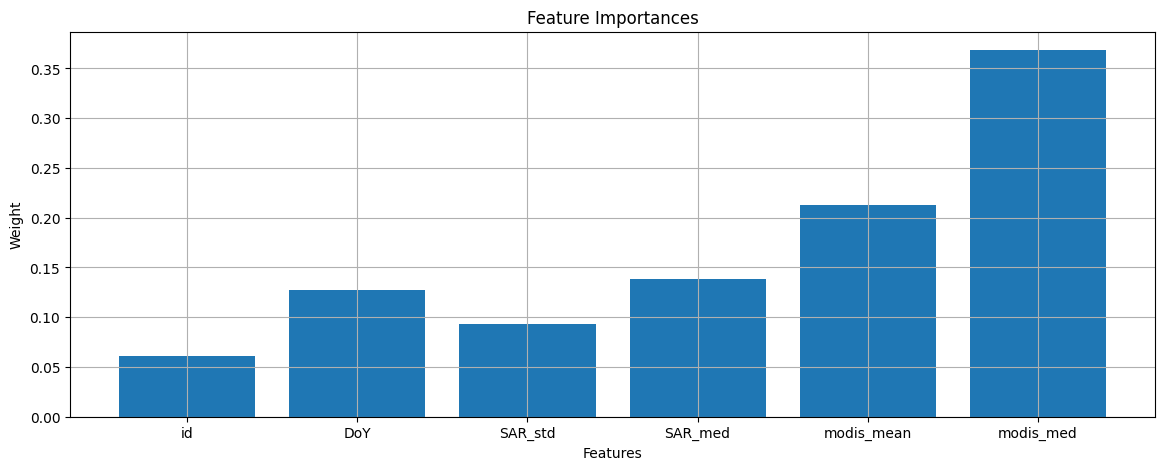

In [162]:
FeaImpPlot(X_train.columns,model.feature_importances_)

In [311]:
# Tunning Parameters - Multi Hyper Parameter
param_grid= {'max_depth': [3,4,5,6,7],
             'eta': [0.001,0.01,0.1,0.3,0.6,0.9],
             'gamma': [0, 10, 30],
             'reg_lambda': [0.001,0.01,0.1,1,5,9],
             'n_estimators':[50, 100, 150, 200]}
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
clf=GridSearchCV(xg.XGBRegressor(random_state=40),param_grid,cv=cv)
clf=clf.fit(X_train,y_train)

# clf.best_score_
#clf.best_estimator_
# Test loss
# y_pred_opt=clf.predict(X_test)
# # score=r2_score(y_test, y_pred_opt)
# # print(score)

KeyboardInterrupt: 

### Data Modeling - SVR

In [158]:
model = SVR(C=6.6, epsilon=0.2)
model.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring = 'neg_root_mean_squared_error'
Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring)
score = Val_score.mean()
print(f'Val Loss: {-score:.2f}')
test_df = test_validation(model,X_test,y_test)
#test_df

Val Loss: 0.16
Test RMSE score: 0.14
Test MAE score: 0.11
The N.o samples larger than 0.1: 19
The Unacceptable Ratio: 0.50


In [317]:
#model.dual_coef_# ((1,16)

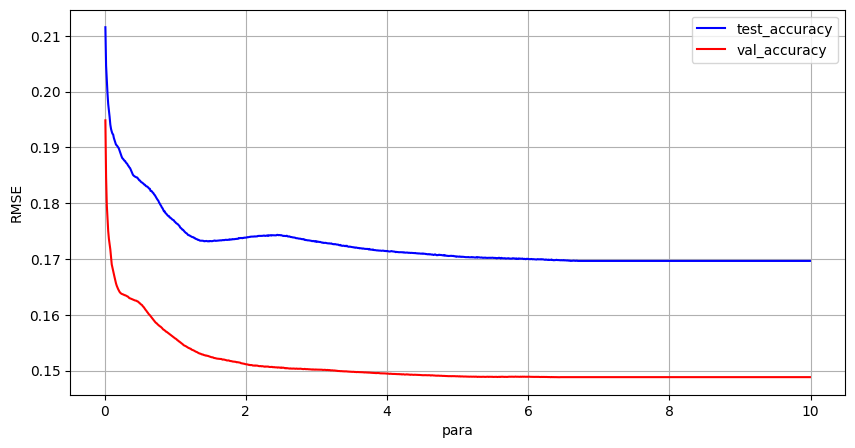

The optimal parameter [6.6]


In [314]:
#### Tuning part
C_max=10 # let learning_rate as a default value - unchange much
C_list=np.arange(0.01,C_max,0.01)
Test_Acc = []
Val_Acc = []
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring_RMSE = 'neg_root_mean_squared_error'
scoring_R2 = 'r2'
for C in C_list:
    model = SVR(C=C, epsilon=0.2)
    model.fit(X_train,y_train)
    
    Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring_RMSE)
    y_pred_test = model.predict(X_test)
    # Accuracy    
    Test_Acc.append(mean_squared_error(y_test, y_pred_test,squared=False))
    Val_Acc.append(-Val_score.mean())

HyperTuningPlot(C_list,Test_Acc,Val_Acc)

### Satcking Example 

In [ ]:
estimators =[
                ('SVR', SVR(C=6.6, epsilon=0.2)),
                ('RFR', RandomForestRegressor(n_estimators=140, max_depth=6,random_state=0)),                
            ]
final_estimator = xg.XGBRegressor(n_estimators=150, max_depth=3, eta=0.01,gamma=0)
reg = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
reg.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring = 'neg_root_mean_squared_error'
Val_score=  cross_val_score(estimator=reg, X=X_train, y=y_train,cv=cv,scoring = scoring)
score = Val_score.mean()
print(f'Val Loss: {-score:.2f}')
test_df,acc = test_validation(reg,X_test,y_test)
# test_df

## Data Modeling - RFR

In [331]:
model = RandomForestRegressor(n_estimators=10,max_depth=9,random_state=0)
scoring = 'neg_root_mean_squared_error'
model = TrainingModel(model,X_train,y_train,scoring)[0]
test_df,acc = test_validation(model,X_test,y_test)
# test_df

Val Loss: 0.14
Test RMSE score: 0.13
Test MAE score: 0.10
The N.o samples larger than 0.1: 9
The Unacceptable Ratio: 0.43


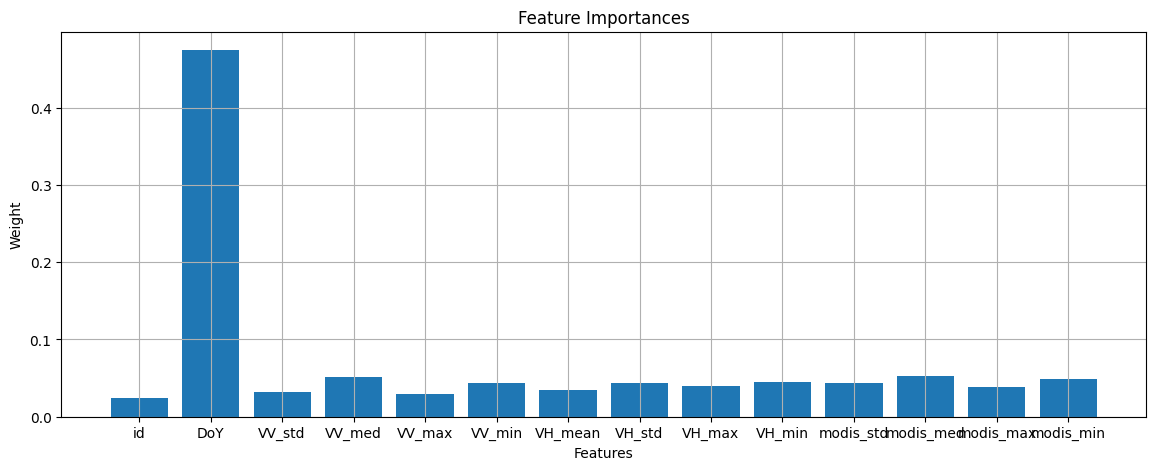

In [230]:
# Model Evaluation
FeaImpPlot(X_train.columns,model.feature_importances_)

In [320]:
## Save Model
title = f'RFR_8field_Tuned_{acc:.2f}_ALL_Features_VV_VH_Filtred.sav'
# SaveModel(model,savePath,title)

In [231]:
Feadf = FeatureSelection(model,X_train,y_train,min_features_to_select=5)  # VV_mean - VH_med - modis_mean
Feadf

Features  Importance
0          id       False
1         DoY        True
2      VV_std        True
3      VV_med        True
4      VV_max       False
5      VV_min        True
6     VH_mean        True
7      VH_std        True
8      VH_max        True
9      VH_min        True
10  modis_std        True
11  modis_med        True
12  modis_max       False
13  modis_min        True

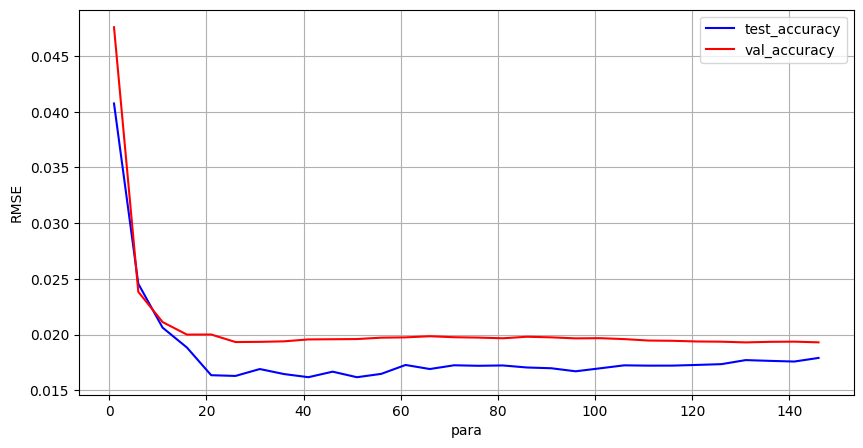

The optimal parameter [51]


In [186]:
C_max= 150 # let learning_rate as a default value - unchange much
C_min = 1
C_list=np.arange(C_min,C_max,5)
Test_Acc = []
Val_Acc = []
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring_MSE = 'neg_mean_squared_error'
scoring_R2 = 'r2'
for C in C_list:
    model = RandomForestRegressor(n_estimators=C, max_depth=16,random_state=0)
    model.fit(X_train,y_train)    
    
    Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring_MSE)
    y_pred_test = model.predict(X_test)
    # Accuracy    
    Test_Acc.append(mean_squared_error(y_test, y_pred_test))
    Val_Acc.append(-Val_score.mean())

HyperTuningPlot(C_list,Test_Acc,Val_Acc)

## Gaussian Processes

In [19]:
import gpytorch
from gpytorch.models import ExactGP
import torch

In [19]:
from tqdm import tqdm
# We are using exact GP inference with a zero mean and RBF kernel
class ExactGPModel(ExactGP):
    '''
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    '''
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Initialize the zero smeans
        self.mean_module = gpytorch.means.ZeroMean()
        # Using the Radial Basis Fuction (RBF) kernal
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return the multvaireateNormal Distribution # Joint Normal Distribution
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def Training_process(training_iter,model,train_x,train_y,optimizer,mll):
    model.train()
    loop = tqdm(range(training_iter))    
    for i in loop:
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % 30 == 0:
            print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
                  f'squared lengthscale: '
                  f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
                  f'noise variance: {model.likelihood.noise.item():.3f}')
        optimizer.step()    

def SaveModelGP(model,title):    
    if not os.path.exists(f'{savePath}/model/'):
        os.makedirs( f'{savePath}/model/')     
    torch.save(model,title)
    
def LoadModelGP(title):
    model = torch.load(title)
    model.eval()
    return model

In [20]:
years = ['2019','2020','2021']
X_train, X_test, y_train, y_test = DataSplitting(preprocessed_dataset,sfd_ids,years,TestRatio = 0.1,random_state=0)

In [21]:
# First let's convert our data into tensors for use with PyTorch
train_x = torch.tensor(np.array(X_train))
train_y = torch.tensor(np.array(y_train))
test_y = torch.tensor(np.array(y_test))

# Initialize Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 1000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer, includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Set our loss as the negative log GP marginal likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [22]:
Training_process(training_iter,model,train_x,train_y,optimizer,mll)

  2%|█▌                                                                              | 19/1000 [00:00<00:10, 97.66it/s]

Iter 1/1000 - Loss: 0.818 squared lengthscale: 0.693 noise variance: 0.693


  6%|████▍                                                                          | 56/1000 [00:00<00:08, 114.24it/s]

Iter 31/1000 - Loss: 0.706 squared lengthscale: 0.848 noise variance: 0.554


  8%|██████▏                                                                        | 79/1000 [00:00<00:08, 108.64it/s]

Iter 61/1000 - Loss: 0.593 squared lengthscale: 0.991 noise variance: 0.435


 12%|████████▉                                                                     | 115/1000 [00:01<00:07, 115.14it/s]

Iter 91/1000 - Loss: 0.479 squared lengthscale: 1.111 noise variance: 0.336


 14%|██████████▊                                                                   | 139/1000 [00:01<00:07, 114.87it/s]

Iter 121/1000 - Loss: 0.367 squared lengthscale: 1.201 noise variance: 0.258


 16%|████████████▋                                                                 | 163/1000 [00:01<00:07, 114.75it/s]

Iter 151/1000 - Loss: 0.261 squared lengthscale: 1.258 noise variance: 0.197


 20%|███████████████▌                                                              | 200/1000 [00:01<00:06, 117.86it/s]

Iter 181/1000 - Loss: 0.166 squared lengthscale: 1.270 noise variance: 0.151


 22%|█████████████████▍                                                            | 224/1000 [00:01<00:06, 114.69it/s]

Iter 211/1000 - Loss: 0.085 squared lengthscale: 1.223 noise variance: 0.117


 26%|████████████████████▎                                                         | 260/1000 [00:02<00:06, 114.09it/s]

Iter 241/1000 - Loss: 0.019 squared lengthscale: 1.114 noise variance: 0.093


 28%|██████████████████████                                                        | 283/1000 [00:02<00:06, 107.16it/s]

Iter 271/1000 - Loss: -0.031 squared lengthscale: 0.988 noise variance: 0.075


 32%|████████████████████████▊                                                     | 318/1000 [00:02<00:06, 108.65it/s]

Iter 301/1000 - Loss: -0.064 squared lengthscale: 0.906 noise variance: 0.063


 34%|██████████████████████████▋                                                   | 342/1000 [00:03<00:05, 109.84it/s]

Iter 331/1000 - Loss: -0.083 squared lengthscale: 0.856 noise variance: 0.055


 38%|█████████████████████████████▋                                                | 380/1000 [00:03<00:05, 117.00it/s]

Iter 361/1000 - Loss: -0.093 squared lengthscale: 0.816 noise variance: 0.050


 40%|███████████████████████████████▌                                              | 404/1000 [00:03<00:05, 116.25it/s]

Iter 391/1000 - Loss: -0.097 squared lengthscale: 0.784 noise variance: 0.046


 44%|██████████████████████████████████▏                                           | 439/1000 [00:03<00:05, 108.41it/s]

Iter 421/1000 - Loss: -0.099 squared lengthscale: 0.760 noise variance: 0.044


 46%|███████████████████████████████████▉                                          | 461/1000 [00:04<00:05, 104.96it/s]

Iter 451/1000 - Loss: -0.099 squared lengthscale: 0.744 noise variance: 0.043


 51%|███████████████████████████████████████▍                                      | 506/1000 [00:04<00:04, 105.68it/s]

Iter 481/1000 - Loss: -0.100 squared lengthscale: 0.733 noise variance: 0.043


 53%|█████████████████████████████████████████▎                                    | 530/1000 [00:04<00:04, 111.26it/s]

Iter 511/1000 - Loss: -0.100 squared lengthscale: 0.727 noise variance: 0.042


 55%|███████████████████████████████████████████▌                                   | 552/1000 [00:05<00:05, 78.34it/s]

Iter 541/1000 - Loss: -0.100 squared lengthscale: 0.723 noise variance: 0.042


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [00:05<00:08, 51.43it/s]

Iter 571/1000 - Loss: -0.100 squared lengthscale: 0.721 noise variance: 0.042


 61%|████████████████████████████████████████████████▎                              | 612/1000 [00:06<00:05, 73.48it/s]

Iter 601/1000 - Loss: -0.100 squared lengthscale: 0.719 noise variance: 0.042


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [00:06<00:03, 96.00it/s]

Iter 631/1000 - Loss: -0.100 squared lengthscale: 0.719 noise variance: 0.042


 68%|█████████████████████████████████████████████████████                         | 680/1000 [00:06<00:02, 107.83it/s]

Iter 661/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 70%|██████████████████████████████████████████████████████▊                       | 703/1000 [00:06<00:02, 109.84it/s]

Iter 691/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 74%|█████████████████████████████████████████████████████████▋                    | 740/1000 [00:07<00:02, 109.97it/s]

Iter 721/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 76%|███████████████████████████████████████████████████████████▌                  | 764/1000 [00:07<00:02, 111.13it/s]

Iter 751/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 80%|██████████████████████████████████████████████████████████████▌               | 802/1000 [00:07<00:01, 116.27it/s]

Iter 781/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 83%|████████████████████████████████████████████████████████████████▋             | 829/1000 [00:08<00:01, 122.93it/s]

Iter 811/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 85%|██████████████████████████████████████████████████████████████████▌           | 854/1000 [00:08<00:01, 115.28it/s]

Iter 841/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 89%|█████████████████████████████████████████████████████████████████████▌        | 892/1000 [00:08<00:00, 120.63it/s]

Iter 871/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 92%|███████████████████████████████████████████████████████████████████████▋      | 919/1000 [00:08<00:00, 125.84it/s]

Iter 901/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 94%|█████████████████████████████████████████████████████████████████████████▋    | 944/1000 [00:09<00:00, 103.86it/s]

Iter 931/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


 97%|███████████████████████████████████████████████████████████████████████████▌  | 969/1000 [00:09<00:00, 110.64it/s]

Iter 961/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.20it/s]

Iter 991/1000 - Loss: -0.100 squared lengthscale: 0.718 noise variance: 0.042


In [23]:
test_df, acc = test_validation(model,X_test,y_test,GP=True)
#test_df

Test RMSE score: 0.18
Test MAE score: 0.15
The N.o samples larger than 0.1: 23
The Unacceptable Ratio: 0.64


In [25]:
# save model
title = f'{savePath}/model/GP_model_{acc:.2f}_wOrdianl.pt'
# SaveModelGP(model,title)
# load model
# model = LoadModelGP(title)

## Prediction

In [332]:
sfd_ids

array([104839603, 104851010, 104851011, 104856056, 104856307, 104838039,
       104856508, 104852841], dtype=int64)

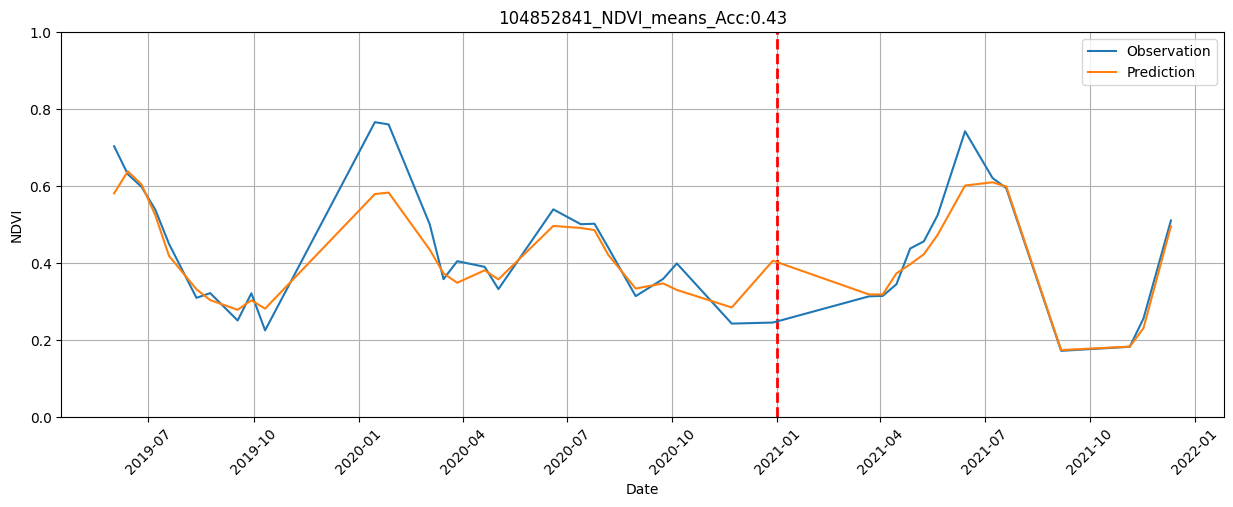

In [340]:
years = ['2019','2020','2021']
sfd_id_choice = 104852841
# title = 'RFR_8field_Tuned_0.31_ALL_Features_VV_VH_DoY_Crop.sav'
# model = loadModel(savePath,title)
all_smooth_feature_df = Pred_Obs_plot(preprocessed_dataset,sfd_id_choice,model,differenceFeatured[3:-1],acc,years=None,GB=False,save=False)

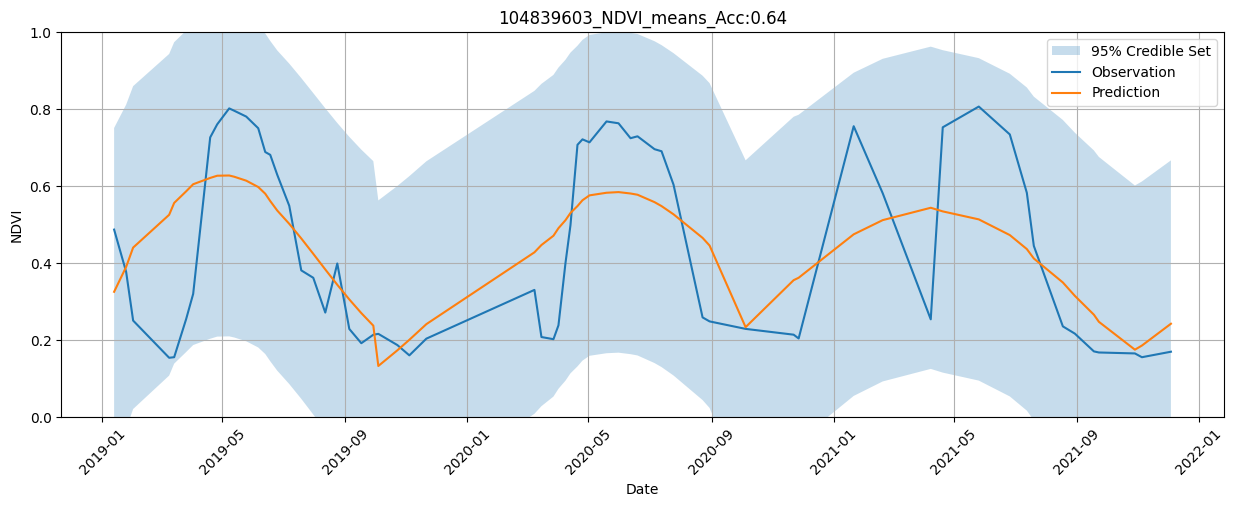

In [25]:
years = ['2019','2020','2021']
all_smooth_feature_df = Pred_Obs_plot(preprocessed_dataset,sfd_id_choice,model,selected[3:-1],acc,years=years,GB=True,Confident_drawing=True,save=False)

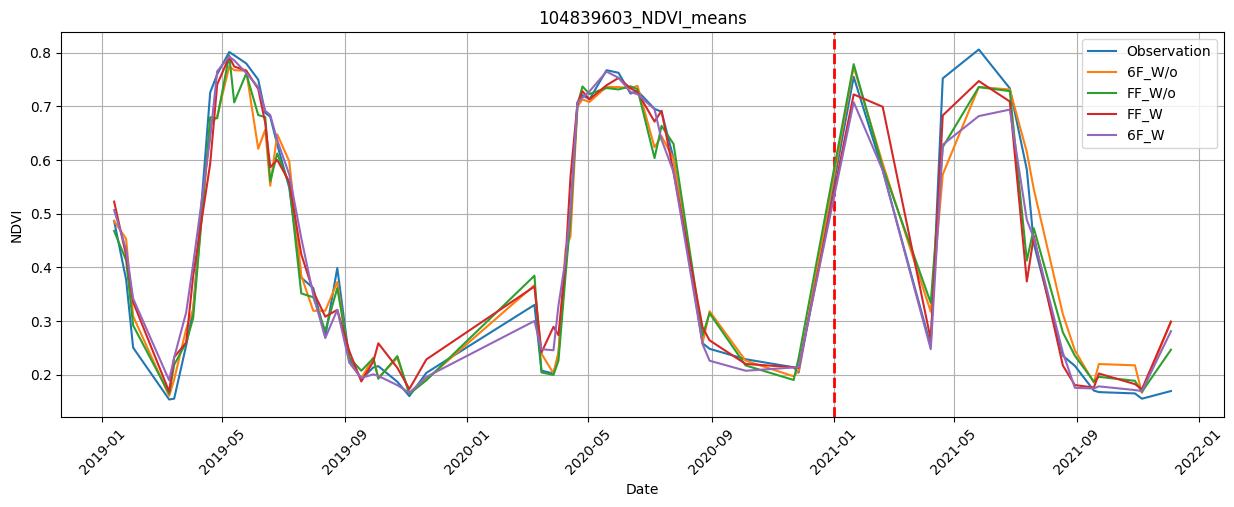

In [684]:
df_dataset = preprocessed_dataset.copy()
df_dataset = df_dataset.set_index(['field_id','year'])    
plt.figure(figsize =(15,5))
title = f'{sfd_id_choice}_NDVI_means'
plt.title(title)
d = datetime(2021,1,1)

plt.axvline(x=d, c='r', lw=2, linestyle='dashed')
plt.plot(Date,NDVI,label='Observation')
plt.plot(Date_pred,six_feature_df['pred'],label='6F_W/o')
plt.plot(Date_pred,all_feature_df['pred'],label='FF_W/o')
plt.plot(Date_pred,all_smooth_feature_df['pred'],label='FF_W')
plt.plot(Date_pred,six_smooth_feature_df['pred'],label='6F_W')
plt.grid()
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('NDVI')
plt.legend(loc = 'upper right')

# Other Predictions

In [299]:
savePath = 'ImageResults/SAR_Rescontruction/'
features = ['id','SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med']

In [300]:
# Example:
field_id = [104839603]
Date = '20190130'
SAR_mean = [0.52]
SAR_std = [0.03]
SAR_med = [0.89]
modis_mean = [0.6]
modis_std = [0.7]
modis_med = [0.9]
# NDVI_mean = ???
dict_pred = {
    'id': field_id,
    'Date': Date,
    'SAR_mean': SAR_mean,
    'SAR_std': SAR_std,
    'SAR_med': SAR_med,
    'modis_mean': modis_mean,
    'modis_std': modis_std,
    'modis_med': modis_med,
}
df_pred = pd.DataFrame(dict_pred)

In [301]:
# Preprocessing the predicted value
df_pred['Date'] = pd.to_datetime(df_pred['Date'],format='%Y%m%d')
df_pred.insert(1, "DoY", df_pred['Date'].apply(lambda x:x.dayofyear), True)
df_pred['id'] = np.where(sfd_ids==field_id)[0][0]

scaler_names = [savePath + feature + '_scaler.gz' for feature in features]
scalers = [joblib.load(scaler_name) for scaler_name in scaler_names ]

for feature,scaler in zip(features,scalers):
    df_pred[feature] = scaler.transform(df_pred[feature].values.reshape(-1,1))
df_pred.drop(['Date'],axis=1,inplace=True)

In [302]:
loaded_model = loadModel(savePath,'RFR_8field_Tuned_model.sav')
# Predict
result = loaded_model.predict(df_pred )
result

array([0.73300785])

In [ ]:
loaded_model

In [303]:
# Last model
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring = 'neg_root_mean_squared_error'
Val_score=  cross_val_score(estimator=loaded_model, X=X_train, y=y_train,cv=cv,scoring = scoring)
score = Val_score.mean()
print(f'Val Loss: {-score:.2f}')
test_df = test_validation(loaded_model,X_test,y_test)

Val Loss: 0.12
Test RMSE score: 0.13
Test MAE score: 0.09
The N.o samples larger than 0.1: 21
The Unacceptable Ratio: 0.30
